Analyse Sit to Stand and develop an accurate classifier for it

In [1]:
import sys
sys.path.append('..')

from utils.constants import *
from utils.file_readers import *
from utils.data_exploration import *
from utils.signal_processing import *
from utils.sliding_window import *
from utils.stand_norm import *

import random
import pandas as pd

from sklearn import metrics
import seaborn as sns

In [2]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Conv1D, Dropout, MaxPooling1D, BatchNormalization
from keras import optimizers

Using TensorFlow backend.


In [3]:
df_all = pd.read_csv('../Preprocessed/all_data.csv')

In [4]:
activity_label = 0

Create comparative plots across subjects for the signals to gauge how easily differentiable they are.

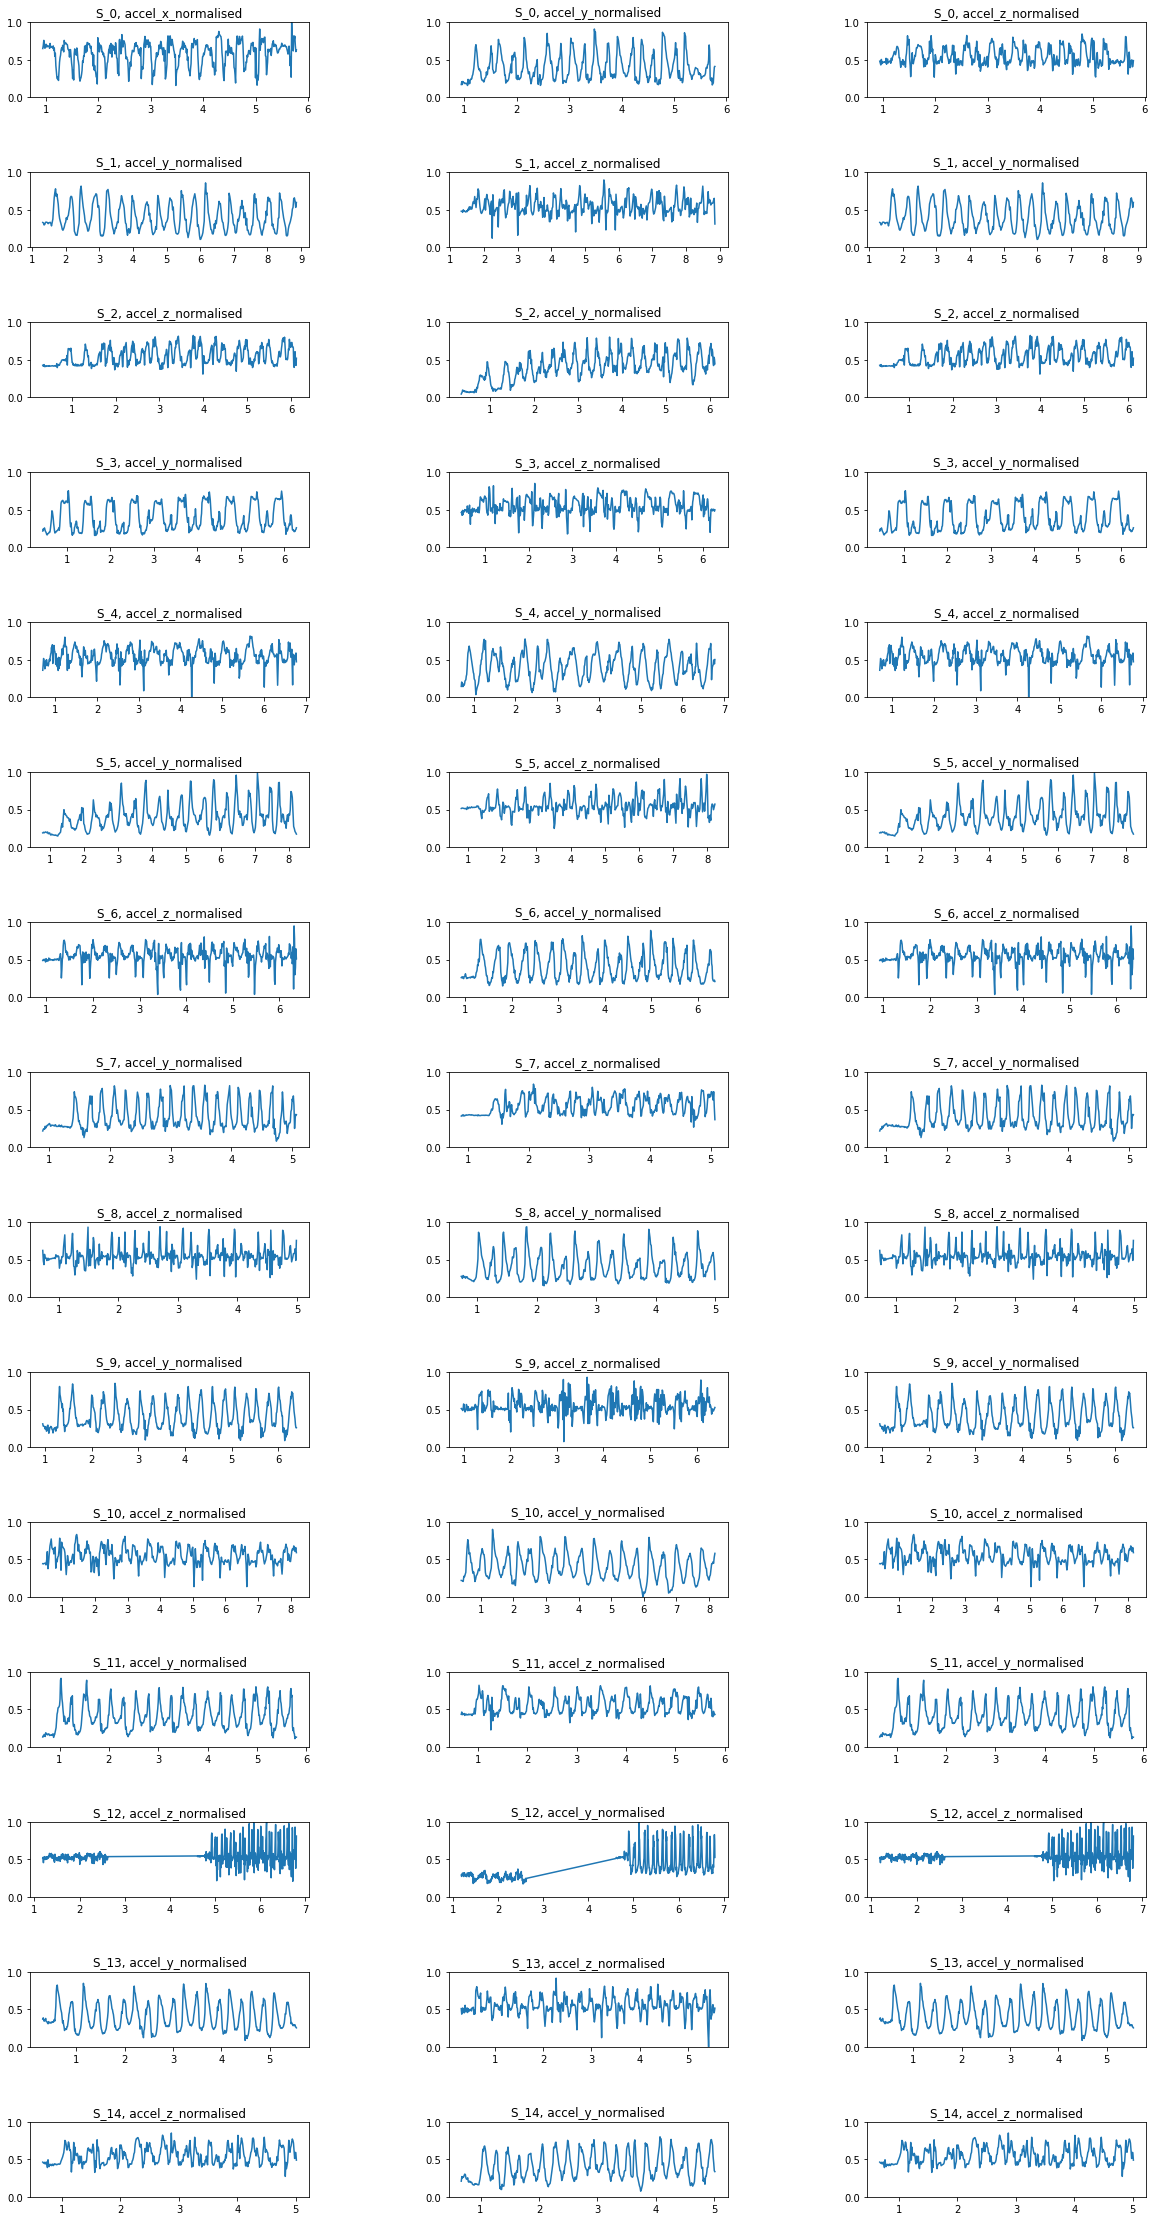

In [5]:
subjects = get_subject_names()
correctness = 'correct'

fig = plt.figure(figsize=(20, 40))
fig.subplots_adjust(hspace=1, wspace=0.5)
subject_counter = 0

axes = ['accel_x_normalised', 'accel_y_normalised', 'accel_z_normalised']
axes_counter = 0

for i in range(1, 3*len(subjects) + 1):
    subject = subjects[subject_counter]
    
    mask = (df_all['subject'] == subject) & (df_all['correctness'] == correctness) & (df_all['activity'] == activity_label)
    
    df_filtered = df_all[mask]
    
    ax = fig.add_subplot(len(subjects), 3, i)
    plt.plot(df_filtered[axes[axes_counter]])
    plt.title("S_{}, {}".format(subject_counter, axes[axes_counter]))
    
    ax.set_ylim((0, 1))
    ax.set_xticklabels(range(len(df_filtered[axes[axes_counter]])))
    
    if i%3 == 0:
        subject_counter += 1
    
    if axes_counter == 2:
        axes_counter = 1
    else:
        axes_counter += 1

### LOSOXV for one activity

In [27]:
def generate_range(n, end, start=0):
    return list(range(start, n)) + list(range(n+1, end))

In [28]:
data = pd.read_csv("../Preprocessed/raw_data.csv")
data = data.reindex(columns=['timestamp', 'seq', 'accel_x', 'accel_y', 'accel_z',
                             'accel_magnitude', 'accel_pca',
                             'subject', 'activity', 'correctness',
                             'accel_x_standardised', 'accel_y_standardised', 'accel_z_standardised',
                             'accel_magnitude_standardised', 'accel_pca_standardised',
                             'accel_x_normalised', 'accel_y_normalised', 'accel_z_normalised',
                             'accel_magnitude_normalised', 'accel_pca_normalised'])

random.seed(42)

In [29]:
subjects = get_subject_names()
n_subjects = len(subjects)

n_train_subjects = 12
n_validation_subjects = 2

In [30]:
activities = 'all'
one_vs_all_activity = 0
correctness = 'correct'

In [31]:
n_time_steps = 38
step = 19
n_features = 3

In [32]:
features = ['accel_x_normalised', 'accel_y_normalised', 'accel_z_normalised']

In [33]:
num_filters = 64
kernel_size = 3
activation = 'relu'

n_classes = 2

In [34]:
def initialise_model():
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                     activation=activation, input_shape=(n_time_steps, n_features)))
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                     activation=activation))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, 
                     activation=activation))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    model.summary()
    return model

In [40]:
# optimiser
sgd = optimizers.SGD(lr=0.0001)

# train model
batch_size = 32
epochs = 200

In [41]:
# dictionaries for statistics
# they will all have keys = left out subject and value = stats 
cm = {}
histories = {}

In [42]:
# dataframe for statistics
losoxv_stats = pd.DataFrame(index=subjects, columns=['train_acc', 'train_loss',
                                                    'valid_acc', 'valid_loss',
                                                    'test_acc', 'test_loss'])

In [43]:
save_path = "../Plots/07_Sit_to_stand/"

Left out subject = adela
Test subjects = ['aggie', 'andrius', 'diana', 'jack', 'joao', 'lukasz', 'nikita', 'rim', 'santi', 'sharan', 'teo', 'zoe']
Validation subjects = ['ron', 'seb']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 117502
New dataframe length = 116737
Removed 765 outliers
Original dataframe length = 8965
New dataframe length = 8895
Removed 70 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Generating datasets
------------------

1788/1788 [==============================] - 2s 1ms/step - loss: 0.3090 - accuracy: 0.9066 - mse: 0.0845 - val_loss: 0.2967 - val_accuracy: 0.9141 - val_mse: 0.0798
Epoch 32/200
1788/1788 [==============================] - 2s 948us/step - loss: 0.3033 - accuracy: 0.9116 - mse: 0.0824 - val_loss: 0.2921 - val_accuracy: 0.9167 - val_mse: 0.0782
Epoch 33/200
1788/1788 [==============================] - 2s 1000us/step - loss: 0.2979 - accuracy: 0.9139 - mse: 0.0804 - val_loss: 0.2874 - val_accuracy: 0.9193 - val_mse: 0.0766
Epoch 34/200
1788/1788 [==============================] - 2s 1ms/step - loss: 0.2924 - accuracy: 0.9139 - mse: 0.0784 - val_loss: 0.2831 - val_accuracy: 0.9193 - val_mse: 0.0751
Epoch 35/200
1788/1788 [==============================] - 2s 872us/step - loss: 0.2889 - accuracy: 0.9155 - mse: 0.0772 - val_loss: 0.2787 - val_accuracy: 0.9193 - val_mse: 0.0736
Epoch 36/200
1788/1788 [==============================] - 2s 1ms/step - loss: 0.2854 - accuracy: 0.9161 - mse: 0.076

Epoch 77/200
1788/1788 [==============================] - 1s 837us/step - loss: 0.1718 - accuracy: 0.9586 - mse: 0.0403 - val_loss: 0.1563 - val_accuracy: 0.9688 - val_mse: 0.0341
Epoch 78/200
1788/1788 [==============================] - 2s 930us/step - loss: 0.1732 - accuracy: 0.9569 - mse: 0.0412 - val_loss: 0.1543 - val_accuracy: 0.9688 - val_mse: 0.0335
Epoch 79/200
1788/1788 [==============================] - 1s 826us/step - loss: 0.1700 - accuracy: 0.9603 - mse: 0.0400 - val_loss: 0.1526 - val_accuracy: 0.9714 - val_mse: 0.0330
Epoch 80/200
1788/1788 [==============================] - 1s 785us/step - loss: 0.1673 - accuracy: 0.9642 - mse: 0.0390 - val_loss: 0.1514 - val_accuracy: 0.9714 - val_mse: 0.0326
Epoch 81/200
1788/1788 [==============================] - 1s 803us/step - loss: 0.1652 - accuracy: 0.9636 - mse: 0.0385 - val_loss: 0.1494 - val_accuracy: 0.9714 - val_mse: 0.0321
Epoch 82/200
1788/1788 [==============================] - 2s 885us/step - loss: 0.1635 - accuracy: 0

1788/1788 [==============================] - 2s 1ms/step - loss: 0.1222 - accuracy: 0.9720 - mse: 0.0276 - val_loss: 0.0999 - val_accuracy: 0.9922 - val_mse: 0.0186
Epoch 123/200
1788/1788 [==============================] - 2s 1ms/step - loss: 0.1185 - accuracy: 0.9748 - mse: 0.0262 - val_loss: 0.0992 - val_accuracy: 0.9922 - val_mse: 0.0184
Epoch 124/200
1788/1788 [==============================] - 3s 2ms/step - loss: 0.1182 - accuracy: 0.9754 - mse: 0.0261 - val_loss: 0.0985 - val_accuracy: 0.9922 - val_mse: 0.0182
Epoch 125/200
1788/1788 [==============================] - 3s 1ms/step - loss: 0.1214 - accuracy: 0.9737 - mse: 0.0274 - val_loss: 0.0976 - val_accuracy: 0.9922 - val_mse: 0.0180
Epoch 126/200
1788/1788 [==============================] - 3s 2ms/step - loss: 0.1185 - accuracy: 0.9737 - mse: 0.0265 - val_loss: 0.0967 - val_accuracy: 0.9922 - val_mse: 0.0178
Epoch 127/200
1788/1788 [==============================] - 2s 1ms/step - loss: 0.1161 - accuracy: 0.9754 - mse: 0.0255 

Epoch 168/200
1788/1788 [==============================] - 3s 1ms/step - loss: 0.0947 - accuracy: 0.9810 - mse: 0.0209 - val_loss: 0.0709 - val_accuracy: 0.9974 - val_mse: 0.0116
Epoch 169/200
1788/1788 [==============================] - 3s 2ms/step - loss: 0.0909 - accuracy: 0.9815 - mse: 0.0194 - val_loss: 0.0707 - val_accuracy: 0.9974 - val_mse: 0.0116
Epoch 170/200
1788/1788 [==============================] - 3s 2ms/step - loss: 0.0935 - accuracy: 0.9765 - mse: 0.0207 - val_loss: 0.0699 - val_accuracy: 0.9974 - val_mse: 0.0114
Epoch 171/200
1788/1788 [==============================] - 3s 1ms/step - loss: 0.0897 - accuracy: 0.9793 - mse: 0.0195 - val_loss: 0.0697 - val_accuracy: 0.9974 - val_mse: 0.0114
Epoch 172/200
1788/1788 [==============================] - 3s 1ms/step - loss: 0.0923 - accuracy: 0.9804 - mse: 0.0203 - val_loss: 0.0688 - val_accuracy: 0.9974 - val_mse: 0.0112
Epoch 173/200
1788/1788 [==============================] - 2s 1ms/step - loss: 0.0915 - accuracy: 0.9815 

Train on 1908 samples, validate on 297 samples
Epoch 1/200
1908/1908 [==============================] - 13s 7ms/step - loss: 0.6791 - accuracy: 0.5922 - mse: 0.2429 - val_loss: 0.6784 - val_accuracy: 0.8283 - val_mse: 0.2426
Epoch 2/200
1908/1908 [==============================] - 3s 1ms/step - loss: 0.6518 - accuracy: 0.6667 - mse: 0.2294 - val_loss: 0.6750 - val_accuracy: 0.8283 - val_mse: 0.2409
Epoch 3/200
1908/1908 [==============================] - 3s 1ms/step - loss: 0.6291 - accuracy: 0.7138 - mse: 0.2183 - val_loss: 0.6711 - val_accuracy: 0.8316 - val_mse: 0.2390
Epoch 4/200
1908/1908 [==============================] - 3s 1ms/step - loss: 0.6091 - accuracy: 0.7678 - mse: 0.2085 - val_loss: 0.6648 - val_accuracy: 0.8283 - val_mse: 0.2359
Epoch 5/200
1908/1908 [==============================] - 3s 1ms/step - loss: 0.5912 - accuracy: 0.7951 - mse: 0.1998 - val_loss: 0.6555 - val_accuracy: 0.8249 - val_mse: 0.2312
Epoch 6/200
1908/1908 [==============================] - 3s 1ms/ste

Epoch 47/200
1908/1908 [==============================] - 3s 1ms/step - loss: 0.3642 - accuracy: 0.8480 - mse: 0.1080 - val_loss: 0.3983 - val_accuracy: 0.8316 - val_mse: 0.1223
Epoch 48/200
1908/1908 [==============================] - 3s 1ms/step - loss: 0.3613 - accuracy: 0.8491 - mse: 0.1070 - val_loss: 0.3954 - val_accuracy: 0.8316 - val_mse: 0.1213
Epoch 49/200
1908/1908 [==============================] - 3s 1ms/step - loss: 0.3582 - accuracy: 0.8485 - mse: 0.1059 - val_loss: 0.3925 - val_accuracy: 0.8350 - val_mse: 0.1204
Epoch 50/200
1908/1908 [==============================] - 3s 1ms/step - loss: 0.3539 - accuracy: 0.8491 - mse: 0.1043 - val_loss: 0.3898 - val_accuracy: 0.8350 - val_mse: 0.1194
Epoch 51/200
1908/1908 [==============================] - 3s 1ms/step - loss: 0.3513 - accuracy: 0.8512 - mse: 0.1035 - val_loss: 0.3872 - val_accuracy: 0.8350 - val_mse: 0.1185
Epoch 52/200
1908/1908 [==============================] - 3s 1ms/step - loss: 0.3484 - accuracy: 0.8517 - mse:

Epoch 93/200
1908/1908 [==============================] - 2s 816us/step - loss: 0.2537 - accuracy: 0.9088 - mse: 0.0691 - val_loss: 0.2941 - val_accuracy: 0.8822 - val_mse: 0.0865
Epoch 94/200
1908/1908 [==============================] - 1s 781us/step - loss: 0.2503 - accuracy: 0.9135 - mse: 0.0678 - val_loss: 0.2926 - val_accuracy: 0.8855 - val_mse: 0.0860
Epoch 95/200
1908/1908 [==============================] - 1s 744us/step - loss: 0.2488 - accuracy: 0.9104 - mse: 0.0675 - val_loss: 0.2907 - val_accuracy: 0.8855 - val_mse: 0.0854
Epoch 96/200
1908/1908 [==============================] - 1s 746us/step - loss: 0.2460 - accuracy: 0.9167 - mse: 0.0664 - val_loss: 0.2887 - val_accuracy: 0.8855 - val_mse: 0.0847
Epoch 97/200
1908/1908 [==============================] - 1s 741us/step - loss: 0.2451 - accuracy: 0.9161 - mse: 0.0661 - val_loss: 0.2870 - val_accuracy: 0.8855 - val_mse: 0.0842
Epoch 98/200
1908/1908 [==============================] - 1s 724us/step - loss: 0.2431 - accuracy: 0

1908/1908 [==============================] - 1s 737us/step - loss: 0.1813 - accuracy: 0.9523 - mse: 0.0450 - val_loss: 0.2262 - val_accuracy: 0.9057 - val_mse: 0.0648
Epoch 139/200
1908/1908 [==============================] - 1s 732us/step - loss: 0.1797 - accuracy: 0.9492 - mse: 0.0446 - val_loss: 0.2249 - val_accuracy: 0.9057 - val_mse: 0.0644
Epoch 140/200
1908/1908 [==============================] - 1s 743us/step - loss: 0.1818 - accuracy: 0.9513 - mse: 0.0454 - val_loss: 0.2240 - val_accuracy: 0.9091 - val_mse: 0.0640
Epoch 141/200
1908/1908 [==============================] - 1s 738us/step - loss: 0.1776 - accuracy: 0.9513 - mse: 0.0440 - val_loss: 0.2227 - val_accuracy: 0.9057 - val_mse: 0.0637
Epoch 142/200
1908/1908 [==============================] - 1s 733us/step - loss: 0.1747 - accuracy: 0.9523 - mse: 0.0428 - val_loss: 0.2216 - val_accuracy: 0.9057 - val_mse: 0.0633
Epoch 143/200
1908/1908 [==============================] - 1s 734us/step - loss: 0.1756 - accuracy: 0.9513 - 

1908/1908 [==============================] - 1s 740us/step - loss: 0.1371 - accuracy: 0.9696 - mse: 0.0320 - val_loss: 0.1829 - val_accuracy: 0.9226 - val_mse: 0.0520
Epoch 184/200
1908/1908 [==============================] - 1s 726us/step - loss: 0.1359 - accuracy: 0.9691 - mse: 0.0317 - val_loss: 0.1822 - val_accuracy: 0.9226 - val_mse: 0.0519
Epoch 185/200
1908/1908 [==============================] - 1s 742us/step - loss: 0.1334 - accuracy: 0.9659 - mse: 0.0308 - val_loss: 0.1814 - val_accuracy: 0.9226 - val_mse: 0.0517
Epoch 186/200
1908/1908 [==============================] - 1s 737us/step - loss: 0.1384 - accuracy: 0.9675 - mse: 0.0326 - val_loss: 0.1805 - val_accuracy: 0.9226 - val_mse: 0.0515
Epoch 187/200
1908/1908 [==============================] - 1s 727us/step - loss: 0.1352 - accuracy: 0.9686 - mse: 0.0317 - val_loss: 0.1799 - val_accuracy: 0.9226 - val_mse: 0.0513
Epoch 188/200
1908/1908 [==============================] - 1s 735us/step - loss: 0.1329 - accuracy: 0.9701 - 

1851/1851 [==============================] - 1s 735us/step - loss: 0.5217 - accuracy: 0.8206 - mse: 0.1684 - val_loss: 0.5304 - val_accuracy: 0.8302 - val_mse: 0.1717
Epoch 13/200
1851/1851 [==============================] - 1s 758us/step - loss: 0.5114 - accuracy: 0.8260 - mse: 0.1639 - val_loss: 0.5130 - val_accuracy: 0.8333 - val_mse: 0.1640
Epoch 14/200
1851/1851 [==============================] - 1s 744us/step - loss: 0.5017 - accuracy: 0.8320 - mse: 0.1597 - val_loss: 0.4990 - val_accuracy: 0.8333 - val_mse: 0.1579
Epoch 15/200
1851/1851 [==============================] - 1s 730us/step - loss: 0.4929 - accuracy: 0.8363 - mse: 0.1559 - val_loss: 0.4879 - val_accuracy: 0.8396 - val_mse: 0.1533
Epoch 16/200
1851/1851 [==============================] - 1s 747us/step - loss: 0.4850 - accuracy: 0.8368 - mse: 0.1525 - val_loss: 0.4783 - val_accuracy: 0.8428 - val_mse: 0.1493
Epoch 17/200
1851/1851 [==============================] - 1s 748us/step - loss: 0.4779 - accuracy: 0.8401 - mse: 

1851/1851 [==============================] - 1s 732us/step - loss: 0.3079 - accuracy: 0.8871 - mse: 0.0859 - val_loss: 0.3013 - val_accuracy: 0.8742 - val_mse: 0.0838
Epoch 58/200
1851/1851 [==============================] - 1s 738us/step - loss: 0.3053 - accuracy: 0.8860 - mse: 0.0850 - val_loss: 0.2985 - val_accuracy: 0.8742 - val_mse: 0.0827
Epoch 59/200
1851/1851 [==============================] - 1s 737us/step - loss: 0.3012 - accuracy: 0.8882 - mse: 0.0836 - val_loss: 0.2953 - val_accuracy: 0.8742 - val_mse: 0.0816
Epoch 60/200
1851/1851 [==============================] - 1s 734us/step - loss: 0.2989 - accuracy: 0.8903 - mse: 0.0828 - val_loss: 0.2928 - val_accuracy: 0.8774 - val_mse: 0.0806
Epoch 61/200
1851/1851 [==============================] - 1s 731us/step - loss: 0.2957 - accuracy: 0.8909 - mse: 0.0817 - val_loss: 0.2896 - val_accuracy: 0.8774 - val_mse: 0.0795
Epoch 62/200
1851/1851 [==============================] - 1s 745us/step - loss: 0.2927 - accuracy: 0.8963 - mse: 

Epoch 103/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.2054 - accuracy: 0.9427 - mse: 0.0513 - val_loss: 0.1897 - val_accuracy: 0.9654 - val_mse: 0.0448
Epoch 104/200
1851/1851 [==============================] - 2s 908us/step - loss: 0.2011 - accuracy: 0.9449 - mse: 0.0497 - val_loss: 0.1880 - val_accuracy: 0.9686 - val_mse: 0.0443
Epoch 105/200
1851/1851 [==============================] - 2s 894us/step - loss: 0.2012 - accuracy: 0.9449 - mse: 0.0500 - val_loss: 0.1861 - val_accuracy: 0.9748 - val_mse: 0.0437
Epoch 106/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1979 - accuracy: 0.9525 - mse: 0.0486 - val_loss: 0.1844 - val_accuracy: 0.9748 - val_mse: 0.0431
Epoch 107/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1966 - accuracy: 0.9476 - mse: 0.0484 - val_loss: 0.1827 - val_accuracy: 0.9748 - val_mse: 0.0426
Epoch 108/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1947 - accuracy: 0.9

Epoch 149/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1439 - accuracy: 0.9697 - mse: 0.0331 - val_loss: 0.1312 - val_accuracy: 0.9811 - val_mse: 0.0279
Epoch 150/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1432 - accuracy: 0.9676 - mse: 0.0331 - val_loss: 0.1302 - val_accuracy: 0.9811 - val_mse: 0.0276
Epoch 151/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1429 - accuracy: 0.9697 - mse: 0.0329 - val_loss: 0.1293 - val_accuracy: 0.9811 - val_mse: 0.0274
Epoch 152/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1429 - accuracy: 0.9687 - mse: 0.0328 - val_loss: 0.1285 - val_accuracy: 0.9811 - val_mse: 0.0272
Epoch 153/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1421 - accuracy: 0.9687 - mse: 0.0328 - val_loss: 0.1276 - val_accuracy: 0.9811 - val_mse: 0.0270
Epoch 154/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1403 - accuracy: 0.9681 

Epoch 195/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1123 - accuracy: 0.9773 - mse: 0.0252 - val_loss: 0.1021 - val_accuracy: 0.9843 - val_mse: 0.0212
Epoch 196/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1132 - accuracy: 0.9735 - mse: 0.0257 - val_loss: 0.1017 - val_accuracy: 0.9843 - val_mse: 0.0211
Epoch 197/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1139 - accuracy: 0.9703 - mse: 0.0260 - val_loss: 0.1013 - val_accuracy: 0.9843 - val_mse: 0.0210
Epoch 198/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1116 - accuracy: 0.9773 - mse: 0.0250 - val_loss: 0.1008 - val_accuracy: 0.9843 - val_mse: 0.0209
Epoch 199/200
1851/1851 [==============================] - 2s 1ms/step - loss: 0.1105 - accuracy: 0.9751 - mse: 0.0249 - val_loss: 0.1004 - val_accuracy: 0.9843 - val_mse: 0.0208
Epoch 200/200
149/149 [==============================] - 0s 512us/step
Final loss = 0.18603868327484835
F

1915/1915 [==============================] - 3s 1ms/step - loss: 0.3842 - accuracy: 0.8486 - mse: 0.1138 - val_loss: 0.3623 - val_accuracy: 0.8596 - val_mse: 0.1044
Epoch 25/200
1915/1915 [==============================] - 3s 1ms/step - loss: 0.3791 - accuracy: 0.8512 - mse: 0.1120 - val_loss: 0.3568 - val_accuracy: 0.8638 - val_mse: 0.1022
Epoch 26/200
1915/1915 [==============================] - 3s 1ms/step - loss: 0.3740 - accuracy: 0.8512 - mse: 0.1102 - val_loss: 0.3517 - val_accuracy: 0.8681 - val_mse: 0.1003
Epoch 27/200
1915/1915 [==============================] - 3s 1ms/step - loss: 0.3702 - accuracy: 0.8507 - mse: 0.1088 - val_loss: 0.3467 - val_accuracy: 0.8723 - val_mse: 0.0983
Epoch 28/200
1915/1915 [==============================] - 3s 1ms/step - loss: 0.3650 - accuracy: 0.8554 - mse: 0.1069 - val_loss: 0.3420 - val_accuracy: 0.8723 - val_mse: 0.0965
Epoch 29/200
1915/1915 [==============================] - 3s 1ms/step - loss: 0.3610 - accuracy: 0.8569 - mse: 0.1056 - val

Epoch 70/200
1915/1915 [==============================] - 2s 1ms/step - loss: 0.2324 - accuracy: 0.9269 - mse: 0.0608 - val_loss: 0.2019 - val_accuracy: 0.9915 - val_mse: 0.0442
Epoch 71/200
1915/1915 [==============================] - 2s 1ms/step - loss: 0.2311 - accuracy: 0.9290 - mse: 0.0605 - val_loss: 0.1996 - val_accuracy: 0.9915 - val_mse: 0.0435
Epoch 72/200
1915/1915 [==============================] - 2s 1ms/step - loss: 0.2284 - accuracy: 0.9295 - mse: 0.0595 - val_loss: 0.1977 - val_accuracy: 0.9915 - val_mse: 0.0428
Epoch 73/200
1915/1915 [==============================] - 2s 1ms/step - loss: 0.2256 - accuracy: 0.9305 - mse: 0.0585 - val_loss: 0.1957 - val_accuracy: 1.0000 - val_mse: 0.0422
Epoch 74/200
1915/1915 [==============================] - 2s 1ms/step - loss: 0.2231 - accuracy: 0.9285 - mse: 0.0576 - val_loss: 0.1938 - val_accuracy: 1.0000 - val_mse: 0.0416
Epoch 75/200
1915/1915 [==============================] - 2s 1ms/step - loss: 0.2221 - accuracy: 0.9332 - mse:

Epoch 116/200
1915/1915 [==============================] - 2s 1ms/step - loss: 0.1633 - accuracy: 0.9593 - mse: 0.0394 - val_loss: 0.1321 - val_accuracy: 1.0000 - val_mse: 0.0245
Epoch 117/200
1915/1915 [==============================] - 2s 1ms/step - loss: 0.1612 - accuracy: 0.9619 - mse: 0.0389 - val_loss: 0.1310 - val_accuracy: 1.0000 - val_mse: 0.0242
Epoch 118/200
1915/1915 [==============================] - 2s 1ms/step - loss: 0.1623 - accuracy: 0.9624 - mse: 0.0395 - val_loss: 0.1300 - val_accuracy: 0.9957 - val_mse: 0.0240
Epoch 119/200
1915/1915 [==============================] - 2s 1ms/step - loss: 0.1586 - accuracy: 0.9614 - mse: 0.0382 - val_loss: 0.1292 - val_accuracy: 0.9915 - val_mse: 0.0238
Epoch 120/200
1915/1915 [==============================] - 2s 1ms/step - loss: 0.1595 - accuracy: 0.9624 - mse: 0.0385 - val_loss: 0.1279 - val_accuracy: 0.9915 - val_mse: 0.0235
Epoch 121/200
1915/1915 [==============================] - 2s 1ms/step - loss: 0.1586 - accuracy: 0.9634 

Epoch 162/200
1915/1915 [==============================] - 2s 914us/step - loss: 0.1285 - accuracy: 0.9681 - mse: 0.0305 - val_loss: 0.0966 - val_accuracy: 0.9915 - val_mse: 0.0172
Epoch 163/200
1915/1915 [==============================] - 2s 950us/step - loss: 0.1271 - accuracy: 0.9681 - mse: 0.0303 - val_loss: 0.0962 - val_accuracy: 0.9915 - val_mse: 0.0172
Epoch 164/200
1915/1915 [==============================] - 2s 946us/step - loss: 0.1245 - accuracy: 0.9702 - mse: 0.0293 - val_loss: 0.0953 - val_accuracy: 0.9915 - val_mse: 0.0170
Epoch 165/200
1915/1915 [==============================] - 2s 953us/step - loss: 0.1255 - accuracy: 0.9692 - mse: 0.0298 - val_loss: 0.0948 - val_accuracy: 0.9915 - val_mse: 0.0169
Epoch 166/200
1915/1915 [==============================] - 2s 938us/step - loss: 0.1235 - accuracy: 0.9697 - mse: 0.0292 - val_loss: 0.0943 - val_accuracy: 0.9915 - val_mse: 0.0168
Epoch 167/200
1915/1915 [==============================] - 2s 942us/step - loss: 0.1264 - accur

Total samples for true activity = 1798
Total samples for false activity = 0
Training set shapes: X_train = (1798, 38, 3), y_train = (1798, 2)
Total samples for true activity = 355
Total samples for false activity = 0
Valid set shapes: X_valid = (355, 38, 3), y_valid = (355, 2)
Total samples for true activity = 169
Total samples for false activity = 0
Test set shapes: X_test = (169, 38, 3), y_test = (169, 2)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 36, 64)            640       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 34, 64)            12352     
_________________________________________________________________
batch_normalization_8 (Batch (None, 34, 64)            256       
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 32,

1798/1798 [==============================] - 3s 1ms/step - loss: 0.3940 - accuracy: 0.8415 - mse: 0.1189 - val_loss: 0.3876 - val_accuracy: 0.8423 - val_mse: 0.1172
Epoch 38/200
1798/1798 [==============================] - 2s 1ms/step - loss: 0.3903 - accuracy: 0.8415 - mse: 0.1175 - val_loss: 0.3849 - val_accuracy: 0.8423 - val_mse: 0.1163
Epoch 39/200
1798/1798 [==============================] - 3s 2ms/step - loss: 0.3878 - accuracy: 0.8415 - mse: 0.1167 - val_loss: 0.3822 - val_accuracy: 0.8423 - val_mse: 0.1155
Epoch 40/200
1798/1798 [==============================] - 2s 1ms/step - loss: 0.3845 - accuracy: 0.8415 - mse: 0.1156 - val_loss: 0.3794 - val_accuracy: 0.8423 - val_mse: 0.1146
Epoch 41/200
1798/1798 [==============================] - 2s 1ms/step - loss: 0.3813 - accuracy: 0.8415 - mse: 0.1144 - val_loss: 0.3765 - val_accuracy: 0.8423 - val_mse: 0.1136
Epoch 42/200
1798/1798 [==============================] - 3s 1ms/step - loss: 0.3782 - accuracy: 0.8415 - mse: 0.1134 - val

1798/1798 [==============================] - 3s 2ms/step - loss: 0.2743 - accuracy: 0.8977 - mse: 0.0761 - val_loss: 0.2830 - val_accuracy: 0.8845 - val_mse: 0.0815
Epoch 84/200
1798/1798 [==============================] - 2s 1ms/step - loss: 0.2722 - accuracy: 0.8971 - mse: 0.0754 - val_loss: 0.2812 - val_accuracy: 0.8845 - val_mse: 0.0809
Epoch 85/200
1798/1798 [==============================] - 2s 1ms/step - loss: 0.2706 - accuracy: 0.8971 - mse: 0.0748 - val_loss: 0.2797 - val_accuracy: 0.8873 - val_mse: 0.0803
Epoch 86/200
1798/1798 [==============================] - 3s 1ms/step - loss: 0.2679 - accuracy: 0.9004 - mse: 0.0739 - val_loss: 0.2777 - val_accuracy: 0.8873 - val_mse: 0.0797
Epoch 87/200
1798/1798 [==============================] - 2s 1ms/step - loss: 0.2665 - accuracy: 0.8999 - mse: 0.0733 - val_loss: 0.2761 - val_accuracy: 0.8901 - val_mse: 0.0790
Epoch 88/200
1798/1798 [==============================] - 2s 1ms/step - loss: 0.2645 - accuracy: 0.9016 - mse: 0.0727 - val

Epoch 129/200
1798/1798 [==============================] - 3s 2ms/step - loss: 0.1965 - accuracy: 0.9472 - mse: 0.0495 - val_loss: 0.2151 - val_accuracy: 0.9268 - val_mse: 0.0582
Epoch 130/200
1798/1798 [==============================] - 3s 1ms/step - loss: 0.1959 - accuracy: 0.9455 - mse: 0.0494 - val_loss: 0.2140 - val_accuracy: 0.9268 - val_mse: 0.0579
Epoch 131/200
1798/1798 [==============================] - 3s 2ms/step - loss: 0.1933 - accuracy: 0.9455 - mse: 0.0484 - val_loss: 0.2129 - val_accuracy: 0.9268 - val_mse: 0.0576
Epoch 132/200
1798/1798 [==============================] - 4s 2ms/step - loss: 0.1932 - accuracy: 0.9483 - mse: 0.0485 - val_loss: 0.2120 - val_accuracy: 0.9296 - val_mse: 0.0572
Epoch 133/200
1798/1798 [==============================] - 4s 2ms/step - loss: 0.1909 - accuracy: 0.9494 - mse: 0.0478 - val_loss: 0.2107 - val_accuracy: 0.9324 - val_mse: 0.0568
Epoch 134/200
1798/1798 [==============================] - 2s 1ms/step - loss: 0.1911 - accuracy: 0.9494 

Epoch 175/200
1798/1798 [==============================] - 3s 1ms/step - loss: 0.1485 - accuracy: 0.9650 - mse: 0.0350 - val_loss: 0.1736 - val_accuracy: 0.9408 - val_mse: 0.0455
Epoch 176/200
1798/1798 [==============================] - 2s 1ms/step - loss: 0.1473 - accuracy: 0.9650 - mse: 0.0348 - val_loss: 0.1730 - val_accuracy: 0.9408 - val_mse: 0.0453
Epoch 177/200
1798/1798 [==============================] - 3s 1ms/step - loss: 0.1463 - accuracy: 0.9633 - mse: 0.0344 - val_loss: 0.1724 - val_accuracy: 0.9408 - val_mse: 0.0451
Epoch 178/200
1798/1798 [==============================] - 3s 1ms/step - loss: 0.1463 - accuracy: 0.9638 - mse: 0.0345 - val_loss: 0.1716 - val_accuracy: 0.9437 - val_mse: 0.0448
Epoch 179/200
1798/1798 [==============================] - 3s 1ms/step - loss: 0.1458 - accuracy: 0.9666 - mse: 0.0342 - val_loss: 0.1711 - val_accuracy: 0.9437 - val_mse: 0.0446
Epoch 180/200
1798/1798 [==============================] - 2s 1ms/step - loss: 0.1459 - accuracy: 0.9661 

1899/1899 [==============================] - 2s 1ms/step - loss: 0.5153 - accuracy: 0.8236 - mse: 0.1654 - val_loss: 0.6474 - val_accuracy: 0.8447 - val_mse: 0.2272
Epoch 5/200
1899/1899 [==============================] - 2s 967us/step - loss: 0.5045 - accuracy: 0.8257 - mse: 0.1608 - val_loss: 0.6292 - val_accuracy: 0.8479 - val_mse: 0.2182
Epoch 6/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.4948 - accuracy: 0.8304 - mse: 0.1566 - val_loss: 0.6059 - val_accuracy: 0.8511 - val_mse: 0.2067
Epoch 7/200
1899/1899 [==============================] - 2s 908us/step - loss: 0.4863 - accuracy: 0.8331 - mse: 0.1530 - val_loss: 0.5781 - val_accuracy: 0.8511 - val_mse: 0.1933
Epoch 8/200
1899/1899 [==============================] - 2s 924us/step - loss: 0.4778 - accuracy: 0.8346 - mse: 0.1495 - val_loss: 0.5461 - val_accuracy: 0.8544 - val_mse: 0.1782
Epoch 9/200
1899/1899 [==============================] - 2s 977us/step - loss: 0.4696 - accuracy: 0.8357 - mse: 0.1462 - 

1899/1899 [==============================] - 4s 2ms/step - loss: 0.2878 - accuracy: 0.9026 - mse: 0.0790 - val_loss: 0.2589 - val_accuracy: 0.9256 - val_mse: 0.0668
Epoch 51/200
1899/1899 [==============================] - 3s 1ms/step - loss: 0.2852 - accuracy: 0.9021 - mse: 0.0779 - val_loss: 0.2554 - val_accuracy: 0.9256 - val_mse: 0.0657
Epoch 52/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.2823 - accuracy: 0.9036 - mse: 0.0770 - val_loss: 0.2526 - val_accuracy: 0.9320 - val_mse: 0.0647
Epoch 53/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.2790 - accuracy: 0.9057 - mse: 0.0757 - val_loss: 0.2500 - val_accuracy: 0.9320 - val_mse: 0.0638
Epoch 54/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.2775 - accuracy: 0.9100 - mse: 0.0751 - val_loss: 0.2470 - val_accuracy: 0.9320 - val_mse: 0.0628
Epoch 55/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.2744 - accuracy: 0.9100 - mse: 0.0741 - val

1899/1899 [==============================] - 2s 1ms/step - loss: 0.1910 - accuracy: 0.9526 - mse: 0.0469 - val_loss: 0.1639 - val_accuracy: 0.9773 - val_mse: 0.0361
Epoch 97/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.1900 - accuracy: 0.9526 - mse: 0.0468 - val_loss: 0.1622 - val_accuracy: 0.9773 - val_mse: 0.0357
Epoch 98/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.1883 - accuracy: 0.9526 - mse: 0.0461 - val_loss: 0.1607 - val_accuracy: 0.9806 - val_mse: 0.0353
Epoch 99/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.1878 - accuracy: 0.9521 - mse: 0.0461 - val_loss: 0.1593 - val_accuracy: 0.9806 - val_mse: 0.0349
Epoch 100/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.1843 - accuracy: 0.9558 - mse: 0.0449 - val_loss: 0.1582 - val_accuracy: 0.9806 - val_mse: 0.0345
Epoch 101/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.1823 - accuracy: 0.9558 - mse: 0.0441 - v

Epoch 142/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.1403 - accuracy: 0.9658 - mse: 0.0326 - val_loss: 0.1177 - val_accuracy: 0.9871 - val_mse: 0.0238
Epoch 143/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.1405 - accuracy: 0.9668 - mse: 0.0329 - val_loss: 0.1165 - val_accuracy: 0.9871 - val_mse: 0.0236
Epoch 144/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.1394 - accuracy: 0.9637 - mse: 0.0327 - val_loss: 0.1160 - val_accuracy: 0.9871 - val_mse: 0.0234
Epoch 145/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.1410 - accuracy: 0.9658 - mse: 0.0329 - val_loss: 0.1160 - val_accuracy: 0.9871 - val_mse: 0.0234
Epoch 146/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.1381 - accuracy: 0.9674 - mse: 0.0323 - val_loss: 0.1150 - val_accuracy: 0.9871 - val_mse: 0.0232
Epoch 147/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.1373 - accuracy: 0.9668 

Epoch 188/200
1899/1899 [==============================] - 3s 1ms/step - loss: 0.1135 - accuracy: 0.9726 - mse: 0.0261 - val_loss: 0.0926 - val_accuracy: 0.9935 - val_mse: 0.0179
Epoch 189/200
1899/1899 [==============================] - 3s 1ms/step - loss: 0.1125 - accuracy: 0.9710 - mse: 0.0257 - val_loss: 0.0923 - val_accuracy: 0.9935 - val_mse: 0.0179
Epoch 190/200
1899/1899 [==============================] - 3s 1ms/step - loss: 0.1136 - accuracy: 0.9721 - mse: 0.0262 - val_loss: 0.0916 - val_accuracy: 0.9935 - val_mse: 0.0177
Epoch 191/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.1127 - accuracy: 0.9731 - mse: 0.0259 - val_loss: 0.0916 - val_accuracy: 0.9935 - val_mse: 0.0177
Epoch 192/200
1899/1899 [==============================] - 2s 1ms/step - loss: 0.1116 - accuracy: 0.9721 - mse: 0.0257 - val_loss: 0.0910 - val_accuracy: 0.9935 - val_mse: 0.0176
Epoch 193/200
1899/1899 [==============================] - 3s 1ms/step - loss: 0.1098 - accuracy: 0.9726 

1913/1913 [==============================] - 2s 1ms/step - loss: 0.4595 - accuracy: 0.8427 - mse: 0.1418 - val_loss: 0.4671 - val_accuracy: 0.8272 - val_mse: 0.1457
Epoch 18/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.4539 - accuracy: 0.8432 - mse: 0.1397 - val_loss: 0.4629 - val_accuracy: 0.8272 - val_mse: 0.1442
Epoch 19/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.4494 - accuracy: 0.8432 - mse: 0.1380 - val_loss: 0.4591 - val_accuracy: 0.8272 - val_mse: 0.1428
Epoch 20/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.4443 - accuracy: 0.8432 - mse: 0.1361 - val_loss: 0.4555 - val_accuracy: 0.8272 - val_mse: 0.1416
Epoch 21/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.4396 - accuracy: 0.8432 - mse: 0.1344 - val_loss: 0.4519 - val_accuracy: 0.8272 - val_mse: 0.1404
Epoch 22/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.4346 - accuracy: 0.8432 - mse: 0.1326 - val

Epoch 63/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.2945 - accuracy: 0.8714 - mse: 0.0847 - val_loss: 0.3438 - val_accuracy: 0.8346 - val_mse: 0.1052
Epoch 64/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.2918 - accuracy: 0.8745 - mse: 0.0837 - val_loss: 0.3416 - val_accuracy: 0.8346 - val_mse: 0.1045
Epoch 65/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.2897 - accuracy: 0.8735 - mse: 0.0829 - val_loss: 0.3396 - val_accuracy: 0.8382 - val_mse: 0.1038
Epoch 66/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.2878 - accuracy: 0.8740 - mse: 0.0825 - val_loss: 0.3374 - val_accuracy: 0.8419 - val_mse: 0.1031
Epoch 67/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.2849 - accuracy: 0.8787 - mse: 0.0813 - val_loss: 0.3354 - val_accuracy: 0.8419 - val_mse: 0.1024
Epoch 68/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.2818 - accuracy: 0.8782 - mse:

Epoch 109/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.2020 - accuracy: 0.9362 - mse: 0.0535 - val_loss: 0.2653 - val_accuracy: 0.8934 - val_mse: 0.0797
Epoch 110/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.2010 - accuracy: 0.9373 - mse: 0.0532 - val_loss: 0.2641 - val_accuracy: 0.8934 - val_mse: 0.0794
Epoch 111/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.1995 - accuracy: 0.9341 - mse: 0.0526 - val_loss: 0.2630 - val_accuracy: 0.8934 - val_mse: 0.0790
Epoch 112/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.1983 - accuracy: 0.9409 - mse: 0.0523 - val_loss: 0.2619 - val_accuracy: 0.8971 - val_mse: 0.0786
Epoch 113/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.1959 - accuracy: 0.9415 - mse: 0.0514 - val_loss: 0.2607 - val_accuracy: 0.8971 - val_mse: 0.0783
Epoch 114/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.1953 - accuracy: 0.9378 

Epoch 155/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.1509 - accuracy: 0.9634 - mse: 0.0378 - val_loss: 0.2257 - val_accuracy: 0.9007 - val_mse: 0.0683
Epoch 156/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.1504 - accuracy: 0.9613 - mse: 0.0377 - val_loss: 0.2251 - val_accuracy: 0.9007 - val_mse: 0.0681
Epoch 157/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.1476 - accuracy: 0.9618 - mse: 0.0367 - val_loss: 0.2246 - val_accuracy: 0.9007 - val_mse: 0.0679
Epoch 158/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.1490 - accuracy: 0.9613 - mse: 0.0374 - val_loss: 0.2240 - val_accuracy: 0.9007 - val_mse: 0.0678
Epoch 159/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.1472 - accuracy: 0.9629 - mse: 0.0367 - val_loss: 0.2234 - val_accuracy: 0.9007 - val_mse: 0.0676
Epoch 160/200
1913/1913 [==============================] - 2s 1ms/step - loss: 0.1472 - accuracy: 0.9629 

136/136 [==============================] - 0s 454us/step
Final loss = 0.15125369258663235
Final accuracy = 0.970588207244873
Left out subject = nikita
Test subjects = ['adela', 'aggie', 'andrius', 'jack', 'joao', 'lukasz', 'rim', 'ron', 'seb', 'sharan', 'teo', 'zoe']
Validation subjects = ['santi', 'diana']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 119172
New dataframe length = 118403
Removed 769 outliers
Original dataframe length = 7295
New dataframe length = 7223
Removed 72 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
---------------------------------------------------------------------------

1881/1881 [==============================] - 2s 1ms/step - loss: 0.3576 - accuracy: 0.8703 - mse: 0.1045 - val_loss: 0.3920 - val_accuracy: 0.8592 - val_mse: 0.1179
Epoch 31/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.3537 - accuracy: 0.8735 - mse: 0.1031 - val_loss: 0.3877 - val_accuracy: 0.8592 - val_mse: 0.1163
Epoch 32/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.3499 - accuracy: 0.8724 - mse: 0.1019 - val_loss: 0.3837 - val_accuracy: 0.8592 - val_mse: 0.1149
Epoch 33/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.3458 - accuracy: 0.8719 - mse: 0.1003 - val_loss: 0.3800 - val_accuracy: 0.8627 - val_mse: 0.1136
Epoch 34/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.3414 - accuracy: 0.8783 - mse: 0.0987 - val_loss: 0.3758 - val_accuracy: 0.8627 - val_mse: 0.1122
Epoch 35/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.3366 - accuracy: 0.8767 - mse: 0.0970 - val

1881/1881 [==============================] - 3s 1ms/step - loss: 0.2174 - accuracy: 0.9447 - mse: 0.0555 - val_loss: 0.2573 - val_accuracy: 0.9225 - val_mse: 0.0717
Epoch 77/200
1881/1881 [==============================] - 3s 1ms/step - loss: 0.2134 - accuracy: 0.9442 - mse: 0.0541 - val_loss: 0.2554 - val_accuracy: 0.9225 - val_mse: 0.0711
Epoch 78/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.2139 - accuracy: 0.9421 - mse: 0.0545 - val_loss: 0.2535 - val_accuracy: 0.9225 - val_mse: 0.0704
Epoch 79/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.2105 - accuracy: 0.9463 - mse: 0.0531 - val_loss: 0.2513 - val_accuracy: 0.9225 - val_mse: 0.0698
Epoch 80/200
1881/1881 [==============================] - 2s 982us/step - loss: 0.2100 - accuracy: 0.9436 - mse: 0.0533 - val_loss: 0.2493 - val_accuracy: 0.9225 - val_mse: 0.0693
Epoch 81/200
1881/1881 [==============================] - 2s 905us/step - loss: 0.2062 - accuracy: 0.9436 - mse: 0.0518 -

Epoch 122/200
1881/1881 [==============================] - 3s 1ms/step - loss: 0.1502 - accuracy: 0.9665 - mse: 0.0350 - val_loss: 0.1909 - val_accuracy: 0.9401 - val_mse: 0.0518
Epoch 123/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1499 - accuracy: 0.9649 - mse: 0.0352 - val_loss: 0.1901 - val_accuracy: 0.9401 - val_mse: 0.0515
Epoch 124/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1504 - accuracy: 0.9665 - mse: 0.0353 - val_loss: 0.1890 - val_accuracy: 0.9401 - val_mse: 0.0512
Epoch 125/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1490 - accuracy: 0.9654 - mse: 0.0349 - val_loss: 0.1882 - val_accuracy: 0.9401 - val_mse: 0.0510
Epoch 126/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1454 - accuracy: 0.9660 - mse: 0.0337 - val_loss: 0.1872 - val_accuracy: 0.9401 - val_mse: 0.0507
Epoch 127/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1463 - accuracy: 0.9670 

Epoch 168/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1153 - accuracy: 0.9729 - mse: 0.0259 - val_loss: 0.1546 - val_accuracy: 0.9437 - val_mse: 0.0421
Epoch 169/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1169 - accuracy: 0.9708 - mse: 0.0265 - val_loss: 0.1539 - val_accuracy: 0.9472 - val_mse: 0.0418
Epoch 170/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1159 - accuracy: 0.9734 - mse: 0.0262 - val_loss: 0.1533 - val_accuracy: 0.9472 - val_mse: 0.0417
Epoch 171/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1125 - accuracy: 0.9750 - mse: 0.0251 - val_loss: 0.1527 - val_accuracy: 0.9472 - val_mse: 0.0415
Epoch 172/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1156 - accuracy: 0.9708 - mse: 0.0264 - val_loss: 0.1522 - val_accuracy: 0.9472 - val_mse: 0.0414
Epoch 173/200
1881/1881 [==============================] - 2s 1ms/step - loss: 0.1143 - accuracy: 0.9750 

Train on 1845 samples, validate on 339 samples
Epoch 1/200
1845/1845 [==============================] - 9s 5ms/step - loss: 0.7504 - accuracy: 0.4390 - mse: 0.2772 - val_loss: 0.7070 - val_accuracy: 0.2035 - val_mse: 0.2569
Epoch 2/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.7034 - accuracy: 0.5257 - mse: 0.2546 - val_loss: 0.6951 - val_accuracy: 0.4425 - val_mse: 0.2510
Epoch 3/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.6658 - accuracy: 0.6163 - mse: 0.2364 - val_loss: 0.6857 - val_accuracy: 0.6667 - val_mse: 0.2463
Epoch 4/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.6367 - accuracy: 0.6797 - mse: 0.2221 - val_loss: 0.6770 - val_accuracy: 0.7463 - val_mse: 0.2419
Epoch 5/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.6122 - accuracy: 0.7279 - mse: 0.2101 - val_loss: 0.6672 - val_accuracy: 0.7758 - val_mse: 0.2370
Epoch 6/200
1845/1845 [==============================] - 2s 1ms/step

Epoch 47/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.3538 - accuracy: 0.8629 - mse: 0.1045 - val_loss: 0.4189 - val_accuracy: 0.8407 - val_mse: 0.1285
Epoch 48/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.3518 - accuracy: 0.8618 - mse: 0.1039 - val_loss: 0.4166 - val_accuracy: 0.8407 - val_mse: 0.1277
Epoch 49/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.3485 - accuracy: 0.8623 - mse: 0.1027 - val_loss: 0.4144 - val_accuracy: 0.8437 - val_mse: 0.1270
Epoch 50/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.3451 - accuracy: 0.8645 - mse: 0.1015 - val_loss: 0.4122 - val_accuracy: 0.8496 - val_mse: 0.1262
Epoch 51/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.3433 - accuracy: 0.8667 - mse: 0.1010 - val_loss: 0.4101 - val_accuracy: 0.8496 - val_mse: 0.1255
Epoch 52/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.3399 - accuracy: 0.8650 - mse:

1845/1845 [==============================] - 2s 1ms/step - loss: 0.2462 - accuracy: 0.9198 - mse: 0.0676 - val_loss: 0.3333 - val_accuracy: 0.8761 - val_mse: 0.1001
Epoch 94/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.2448 - accuracy: 0.9230 - mse: 0.0671 - val_loss: 0.3317 - val_accuracy: 0.8761 - val_mse: 0.0997
Epoch 95/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.2431 - accuracy: 0.9203 - mse: 0.0666 - val_loss: 0.3306 - val_accuracy: 0.8761 - val_mse: 0.0993
Epoch 96/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.2404 - accuracy: 0.9274 - mse: 0.0655 - val_loss: 0.3293 - val_accuracy: 0.8761 - val_mse: 0.0989
Epoch 97/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.2397 - accuracy: 0.9225 - mse: 0.0654 - val_loss: 0.3281 - val_accuracy: 0.8761 - val_mse: 0.0985
Epoch 98/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.2379 - accuracy: 0.9263 - mse: 0.0648 - val

Epoch 139/200
1845/1845 [==============================] - 2s 844us/step - loss: 0.1857 - accuracy: 0.9528 - mse: 0.0478 - val_loss: 0.2843 - val_accuracy: 0.8879 - val_mse: 0.0853
Epoch 140/200
1845/1845 [==============================] - 2s 834us/step - loss: 0.1839 - accuracy: 0.9523 - mse: 0.0471 - val_loss: 0.2836 - val_accuracy: 0.8879 - val_mse: 0.0851
Epoch 141/200
1845/1845 [==============================] - 2s 823us/step - loss: 0.1841 - accuracy: 0.9523 - mse: 0.0473 - val_loss: 0.2829 - val_accuracy: 0.8909 - val_mse: 0.0849
Epoch 142/200
1845/1845 [==============================] - 2s 834us/step - loss: 0.1843 - accuracy: 0.9501 - mse: 0.0475 - val_loss: 0.2820 - val_accuracy: 0.8909 - val_mse: 0.0847
Epoch 143/200
1845/1845 [==============================] - 2s 820us/step - loss: 0.1810 - accuracy: 0.9556 - mse: 0.0462 - val_loss: 0.2809 - val_accuracy: 0.8909 - val_mse: 0.0844
Epoch 144/200
1845/1845 [==============================] - 2s 823us/step - loss: 0.1788 - accur

1845/1845 [==============================] - 2s 1ms/step - loss: 0.1460 - accuracy: 0.9637 - mse: 0.0357 - val_loss: 0.2510 - val_accuracy: 0.8997 - val_mse: 0.0755
Epoch 185/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.1448 - accuracy: 0.9648 - mse: 0.0352 - val_loss: 0.2508 - val_accuracy: 0.8997 - val_mse: 0.0754
Epoch 186/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.1456 - accuracy: 0.9669 - mse: 0.0357 - val_loss: 0.2500 - val_accuracy: 0.8997 - val_mse: 0.0751
Epoch 187/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.1442 - accuracy: 0.9653 - mse: 0.0352 - val_loss: 0.2495 - val_accuracy: 0.8997 - val_mse: 0.0750
Epoch 188/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.1452 - accuracy: 0.9642 - mse: 0.0356 - val_loss: 0.2489 - val_accuracy: 0.8997 - val_mse: 0.0748
Epoch 189/200
1845/1845 [==============================] - 2s 1ms/step - loss: 0.1439 - accuracy: 0.9669 - mse: 0.0353 

1803/1803 [==============================] - 2s 1ms/step - loss: 0.4422 - accuracy: 0.8392 - mse: 0.1357 - val_loss: 0.4551 - val_accuracy: 0.8360 - val_mse: 0.1407
Epoch 14/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.4363 - accuracy: 0.8397 - mse: 0.1336 - val_loss: 0.4432 - val_accuracy: 0.8360 - val_mse: 0.1364
Epoch 15/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.4305 - accuracy: 0.8397 - mse: 0.1315 - val_loss: 0.4331 - val_accuracy: 0.8360 - val_mse: 0.1328
Epoch 16/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.4246 - accuracy: 0.8408 - mse: 0.1294 - val_loss: 0.4250 - val_accuracy: 0.8360 - val_mse: 0.1300
Epoch 17/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.4191 - accuracy: 0.8425 - mse: 0.1275 - val_loss: 0.4177 - val_accuracy: 0.8423 - val_mse: 0.1274
Epoch 18/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.4133 - accuracy: 0.8425 - mse: 0.1255 - val

1803/1803 [==============================] - 2s 1ms/step - loss: 0.2441 - accuracy: 0.9201 - mse: 0.0652 - val_loss: 0.2334 - val_accuracy: 0.9306 - val_mse: 0.0594
Epoch 60/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.2422 - accuracy: 0.9212 - mse: 0.0644 - val_loss: 0.2301 - val_accuracy: 0.9306 - val_mse: 0.0582
Epoch 61/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.2385 - accuracy: 0.9246 - mse: 0.0631 - val_loss: 0.2271 - val_accuracy: 0.9338 - val_mse: 0.0571
Epoch 62/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.2355 - accuracy: 0.9262 - mse: 0.0621 - val_loss: 0.2240 - val_accuracy: 0.9338 - val_mse: 0.0560
Epoch 63/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.2333 - accuracy: 0.9268 - mse: 0.0614 - val_loss: 0.2212 - val_accuracy: 0.9338 - val_mse: 0.0549
Epoch 64/200
1803/1803 [==============================] - 3s 2ms/step - loss: 0.2311 - accuracy: 0.9262 - mse: 0.0607 - val

1803/1803 [==============================] - 2s 1ms/step - loss: 0.1475 - accuracy: 0.9656 - mse: 0.0335 - val_loss: 0.1294 - val_accuracy: 0.9874 - val_mse: 0.0240
Epoch 106/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.1446 - accuracy: 0.9678 - mse: 0.0326 - val_loss: 0.1277 - val_accuracy: 0.9874 - val_mse: 0.0235
Epoch 107/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.1461 - accuracy: 0.9651 - mse: 0.0334 - val_loss: 0.1260 - val_accuracy: 0.9905 - val_mse: 0.0231
Epoch 108/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.1431 - accuracy: 0.9662 - mse: 0.0322 - val_loss: 0.1248 - val_accuracy: 0.9905 - val_mse: 0.0227
Epoch 109/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.1411 - accuracy: 0.9673 - mse: 0.0316 - val_loss: 0.1233 - val_accuracy: 0.9905 - val_mse: 0.0223
Epoch 110/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.1401 - accuracy: 0.9684 - mse: 0.0314 

Epoch 151/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.1040 - accuracy: 0.9773 - mse: 0.0221 - val_loss: 0.0805 - val_accuracy: 1.0000 - val_mse: 0.0116
Epoch 152/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.1024 - accuracy: 0.9784 - mse: 0.0215 - val_loss: 0.0800 - val_accuracy: 1.0000 - val_mse: 0.0115
Epoch 153/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.1009 - accuracy: 0.9795 - mse: 0.0212 - val_loss: 0.0794 - val_accuracy: 1.0000 - val_mse: 0.0113
Epoch 154/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.0997 - accuracy: 0.9795 - mse: 0.0209 - val_loss: 0.0787 - val_accuracy: 1.0000 - val_mse: 0.0112
Epoch 155/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.1020 - accuracy: 0.9800 - mse: 0.0218 - val_loss: 0.0780 - val_accuracy: 1.0000 - val_mse: 0.0110
Epoch 156/200
1803/1803 [==============================] - 2s 1ms/step - loss: 0.0966 - accuracy: 0.9800 

Epoch 197/200
1803/1803 [==============================] - 2s 836us/step - loss: 0.0792 - accuracy: 0.9856 - mse: 0.0164 - val_loss: 0.0570 - val_accuracy: 1.0000 - val_mse: 0.0069
Epoch 198/200
1803/1803 [==============================] - 1s 824us/step - loss: 0.0774 - accuracy: 0.9861 - mse: 0.0158 - val_loss: 0.0567 - val_accuracy: 1.0000 - val_mse: 0.0068
Epoch 199/200
1803/1803 [==============================] - 2s 849us/step - loss: 0.0775 - accuracy: 0.9828 - mse: 0.0158 - val_loss: 0.0563 - val_accuracy: 1.0000 - val_mse: 0.0067
Epoch 200/200
199/199 [==============================] - 0s 355us/step
Final loss = 0.07282864064652117
Final accuracy = 1.0
Left out subject = santi
Test subjects = ['andrius', 'diana', 'jack', 'joao', 'lukasz', 'nikita', 'rim', 'ron', 'seb', 'sharan', 'teo', 'zoe']
Validation subjects = ['adela', 'aggie']
--------------------------------------------------------------------------------
Removing outliers
-------------------------------------------------

1927/1927 [==============================] - 2s 1ms/step - loss: 0.4188 - accuracy: 0.8402 - mse: 0.1263 - val_loss: 0.4116 - val_accuracy: 0.8507 - val_mse: 0.1234
Epoch 27/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.4134 - accuracy: 0.8396 - mse: 0.1243 - val_loss: 0.4063 - val_accuracy: 0.8507 - val_mse: 0.1214
Epoch 28/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.4089 - accuracy: 0.8412 - mse: 0.1227 - val_loss: 0.4009 - val_accuracy: 0.8507 - val_mse: 0.1194
Epoch 29/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.4031 - accuracy: 0.8422 - mse: 0.1205 - val_loss: 0.3961 - val_accuracy: 0.8545 - val_mse: 0.1175
Epoch 30/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.3982 - accuracy: 0.8433 - mse: 0.1186 - val_loss: 0.3914 - val_accuracy: 0.8582 - val_mse: 0.1157
Epoch 31/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.3941 - accuracy: 0.8443 - mse: 0.1171 - val

1927/1927 [==============================] - 2s 1ms/step - loss: 0.2596 - accuracy: 0.9170 - mse: 0.0692 - val_loss: 0.2475 - val_accuracy: 0.9328 - val_mse: 0.0640
Epoch 73/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.2565 - accuracy: 0.9175 - mse: 0.0682 - val_loss: 0.2450 - val_accuracy: 0.9328 - val_mse: 0.0631
Epoch 74/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.2535 - accuracy: 0.9206 - mse: 0.0671 - val_loss: 0.2430 - val_accuracy: 0.9328 - val_mse: 0.0624
Epoch 75/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.2522 - accuracy: 0.9211 - mse: 0.0668 - val_loss: 0.2404 - val_accuracy: 0.9366 - val_mse: 0.0616
Epoch 76/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.2504 - accuracy: 0.9216 - mse: 0.0664 - val_loss: 0.2379 - val_accuracy: 0.9366 - val_mse: 0.0608
Epoch 77/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.2473 - accuracy: 0.9253 - mse: 0.0653 - val

Epoch 118/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.1716 - accuracy: 0.9585 - mse: 0.0410 - val_loss: 0.1558 - val_accuracy: 0.9776 - val_mse: 0.0342
Epoch 119/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.1713 - accuracy: 0.9590 - mse: 0.0411 - val_loss: 0.1544 - val_accuracy: 0.9776 - val_mse: 0.0337
Epoch 120/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.1704 - accuracy: 0.9574 - mse: 0.0408 - val_loss: 0.1536 - val_accuracy: 0.9776 - val_mse: 0.0335
Epoch 121/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.1695 - accuracy: 0.9569 - mse: 0.0405 - val_loss: 0.1523 - val_accuracy: 0.9776 - val_mse: 0.0332
Epoch 122/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.1671 - accuracy: 0.9585 - mse: 0.0398 - val_loss: 0.1505 - val_accuracy: 0.9776 - val_mse: 0.0327
Epoch 123/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.1650 - accuracy: 0.9637 

Epoch 164/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.1250 - accuracy: 0.9746 - mse: 0.0281 - val_loss: 0.1068 - val_accuracy: 0.9851 - val_mse: 0.0202
Epoch 165/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.1247 - accuracy: 0.9730 - mse: 0.0281 - val_loss: 0.1055 - val_accuracy: 0.9851 - val_mse: 0.0199
Epoch 166/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.1257 - accuracy: 0.9725 - mse: 0.0284 - val_loss: 0.1044 - val_accuracy: 0.9851 - val_mse: 0.0197
Epoch 167/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.1248 - accuracy: 0.9756 - mse: 0.0282 - val_loss: 0.1035 - val_accuracy: 0.9851 - val_mse: 0.0194
Epoch 168/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.1224 - accuracy: 0.9751 - mse: 0.0274 - val_loss: 0.1029 - val_accuracy: 0.9888 - val_mse: 0.0192
Epoch 169/200
1927/1927 [==============================] - 2s 1ms/step - loss: 0.1219 - accuracy: 0.9756 

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


122/122 [==============================] - 0s 449us/step
Final loss = 0.06601905370833444
Final accuracy = 1.0
Left out subject = seb
Test subjects = ['adela', 'aggie', 'andrius', 'diana', 'jack', 'joao', 'nikita', 'rim', 'ron', 'santi', 'sharan', 'zoe']
Validation subjects = ['teo', 'lukasz']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 118702
New dataframe length = 117950
Removed 752 outliers
Original dataframe length = 7765
New dataframe length = 7680
Removed 85 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------------
--------

1836/1836 [==============================] - 2s 888us/step - loss: 0.4151 - accuracy: 0.8404 - mse: 0.1268 - val_loss: 0.4350 - val_accuracy: 0.8295 - val_mse: 0.1358
Epoch 31/200
1836/1836 [==============================] - 2s 895us/step - loss: 0.4130 - accuracy: 0.8404 - mse: 0.1261 - val_loss: 0.4317 - val_accuracy: 0.8295 - val_mse: 0.1347
Epoch 32/200
1836/1836 [==============================] - 2s 877us/step - loss: 0.4095 - accuracy: 0.8404 - mse: 0.1248 - val_loss: 0.4284 - val_accuracy: 0.8295 - val_mse: 0.1335
Epoch 33/200
1836/1836 [==============================] - 2s 839us/step - loss: 0.4063 - accuracy: 0.8404 - mse: 0.1237 - val_loss: 0.4253 - val_accuracy: 0.8295 - val_mse: 0.1324
Epoch 34/200
1836/1836 [==============================] - 2s 836us/step - loss: 0.4033 - accuracy: 0.8404 - mse: 0.1226 - val_loss: 0.4220 - val_accuracy: 0.8295 - val_mse: 0.1313
Epoch 35/200
1836/1836 [==============================] - 2s 838us/step - loss: 0.4004 - accuracy: 0.8404 - mse: 

1836/1836 [==============================] - 2s 1ms/step - loss: 0.3048 - accuracy: 0.8813 - mse: 0.0873 - val_loss: 0.3158 - val_accuracy: 0.8492 - val_mse: 0.0922
Epoch 77/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.3031 - accuracy: 0.8791 - mse: 0.0868 - val_loss: 0.3136 - val_accuracy: 0.8525 - val_mse: 0.0914
Epoch 78/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.3013 - accuracy: 0.8818 - mse: 0.0862 - val_loss: 0.3114 - val_accuracy: 0.8557 - val_mse: 0.0906
Epoch 79/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.2986 - accuracy: 0.8824 - mse: 0.0851 - val_loss: 0.3092 - val_accuracy: 0.8590 - val_mse: 0.0898
Epoch 80/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.2972 - accuracy: 0.8824 - mse: 0.0846 - val_loss: 0.3072 - val_accuracy: 0.8590 - val_mse: 0.0890
Epoch 81/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.2944 - accuracy: 0.8840 - mse: 0.0836 - val

Epoch 122/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.2277 - accuracy: 0.9314 - mse: 0.0602 - val_loss: 0.2297 - val_accuracy: 0.9443 - val_mse: 0.0599
Epoch 123/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.2259 - accuracy: 0.9346 - mse: 0.0596 - val_loss: 0.2280 - val_accuracy: 0.9443 - val_mse: 0.0593
Epoch 124/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.2259 - accuracy: 0.9325 - mse: 0.0596 - val_loss: 0.2266 - val_accuracy: 0.9443 - val_mse: 0.0589
Epoch 125/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.2233 - accuracy: 0.9352 - mse: 0.0587 - val_loss: 0.2251 - val_accuracy: 0.9410 - val_mse: 0.0583
Epoch 126/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.2236 - accuracy: 0.9325 - mse: 0.0589 - val_loss: 0.2236 - val_accuracy: 0.9443 - val_mse: 0.0578
Epoch 127/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.2228 - accuracy: 0.9363 

Epoch 168/200
1836/1836 [==============================] - 3s 1ms/step - loss: 0.1782 - accuracy: 0.9504 - mse: 0.0443 - val_loss: 0.1723 - val_accuracy: 0.9705 - val_mse: 0.0410
Epoch 169/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.1771 - accuracy: 0.9553 - mse: 0.0439 - val_loss: 0.1714 - val_accuracy: 0.9705 - val_mse: 0.0407
Epoch 170/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.1754 - accuracy: 0.9537 - mse: 0.0436 - val_loss: 0.1703 - val_accuracy: 0.9705 - val_mse: 0.0404
Epoch 171/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.1742 - accuracy: 0.9553 - mse: 0.0430 - val_loss: 0.1696 - val_accuracy: 0.9705 - val_mse: 0.0402
Epoch 172/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.1724 - accuracy: 0.9559 - mse: 0.0424 - val_loss: 0.1688 - val_accuracy: 0.9672 - val_mse: 0.0399
Epoch 173/200
1836/1836 [==============================] - 2s 1ms/step - loss: 0.1725 - accuracy: 0.9559 

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


178/178 [==============================] - 0s 514us/step
Final loss = 0.14648244266262214
Final accuracy = 0.949438214302063
Left out subject = sharan
Test subjects = ['adela', 'aggie', 'diana', 'joao', 'lukasz', 'nikita', 'rim', 'ron', 'santi', 'seb', 'teo', 'zoe']
Validation subjects = ['andrius', 'jack']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 116542
New dataframe length = 115813
Removed 729 outliers
Original dataframe length = 9925
New dataframe length = 9825
Removed 100 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------

1801/1801 [==============================] - 2s 1ms/step - loss: 0.4000 - accuracy: 0.8579 - mse: 0.1189 - val_loss: 0.4674 - val_accuracy: 0.8106 - val_mse: 0.1463
Epoch 31/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.3947 - accuracy: 0.8606 - mse: 0.1168 - val_loss: 0.4633 - val_accuracy: 0.8137 - val_mse: 0.1448
Epoch 32/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.3904 - accuracy: 0.8617 - mse: 0.1152 - val_loss: 0.4593 - val_accuracy: 0.8137 - val_mse: 0.1433
Epoch 33/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.3854 - accuracy: 0.8645 - mse: 0.1134 - val_loss: 0.4554 - val_accuracy: 0.8137 - val_mse: 0.1418
Epoch 34/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.3813 - accuracy: 0.8679 - mse: 0.1118 - val_loss: 0.4519 - val_accuracy: 0.8168 - val_mse: 0.1405
Epoch 35/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.3766 - accuracy: 0.8690 - mse: 0.1102 - val

1801/1801 [==============================] - 2s 931us/step - loss: 0.2473 - accuracy: 0.9262 - mse: 0.0642 - val_loss: 0.3343 - val_accuracy: 0.8882 - val_mse: 0.0959
Epoch 77/200
1801/1801 [==============================] - 2s 968us/step - loss: 0.2437 - accuracy: 0.9273 - mse: 0.0628 - val_loss: 0.3327 - val_accuracy: 0.8882 - val_mse: 0.0953
Epoch 78/200
1801/1801 [==============================] - 2s 991us/step - loss: 0.2425 - accuracy: 0.9278 - mse: 0.0625 - val_loss: 0.3309 - val_accuracy: 0.8882 - val_mse: 0.0947
Epoch 79/200
1801/1801 [==============================] - 2s 991us/step - loss: 0.2398 - accuracy: 0.9328 - mse: 0.0616 - val_loss: 0.3291 - val_accuracy: 0.8882 - val_mse: 0.0940
Epoch 80/200
1801/1801 [==============================] - 2s 888us/step - loss: 0.2371 - accuracy: 0.9367 - mse: 0.0608 - val_loss: 0.3273 - val_accuracy: 0.8882 - val_mse: 0.0934
Epoch 81/200
1801/1801 [==============================] - 2s 886us/step - loss: 0.2340 - accuracy: 0.9361 - mse: 

Epoch 122/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.1680 - accuracy: 0.9661 - mse: 0.0387 - val_loss: 0.2674 - val_accuracy: 0.9099 - val_mse: 0.0728
Epoch 123/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.1673 - accuracy: 0.9650 - mse: 0.0388 - val_loss: 0.2662 - val_accuracy: 0.9099 - val_mse: 0.0725
Epoch 124/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.1649 - accuracy: 0.9706 - mse: 0.0378 - val_loss: 0.2654 - val_accuracy: 0.9099 - val_mse: 0.0722
Epoch 125/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.1645 - accuracy: 0.9722 - mse: 0.0378 - val_loss: 0.2640 - val_accuracy: 0.9099 - val_mse: 0.0718
Epoch 126/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.1645 - accuracy: 0.9672 - mse: 0.0379 - val_loss: 0.2633 - val_accuracy: 0.9099 - val_mse: 0.0715
Epoch 127/200
1801/1801 [==============================] - 3s 1ms/step - loss: 0.1628 - accuracy: 0.9678 

Epoch 168/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.1236 - accuracy: 0.9811 - mse: 0.0265 - val_loss: 0.2315 - val_accuracy: 0.9224 - val_mse: 0.0613
Epoch 169/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.1250 - accuracy: 0.9783 - mse: 0.0270 - val_loss: 0.2311 - val_accuracy: 0.9224 - val_mse: 0.0612
Epoch 170/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.1244 - accuracy: 0.9811 - mse: 0.0266 - val_loss: 0.2306 - val_accuracy: 0.9224 - val_mse: 0.0610
Epoch 171/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.1257 - accuracy: 0.9767 - mse: 0.0273 - val_loss: 0.2298 - val_accuracy: 0.9224 - val_mse: 0.0608
Epoch 172/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.1245 - accuracy: 0.9789 - mse: 0.0271 - val_loss: 0.2291 - val_accuracy: 0.9224 - val_mse: 0.0606
Epoch 173/200
1801/1801 [==============================] - 2s 1ms/step - loss: 0.1206 - accuracy: 0.9822 

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


198/198 [==============================] - 0s 451us/step
Final loss = 0.30477662634744185
Final accuracy = 0.868686854839325
Left out subject = teo
Test subjects = ['adela', 'aggie', 'andrius', 'diana', 'jack', 'lukasz', 'nikita', 'rim', 'santi', 'seb', 'sharan', 'zoe']
Validation subjects = ['ron', 'joao']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 118032
New dataframe length = 117297
Removed 735 outliers
Original dataframe length = 8435
New dataframe length = 8364
Removed 71 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
---------------------------------------------------------------------------

1842/1842 [==============================] - 2s 1ms/step - loss: 0.4290 - accuracy: 0.8355 - mse: 0.1316 - val_loss: 0.4069 - val_accuracy: 0.8576 - val_mse: 0.1212
Epoch 31/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.4264 - accuracy: 0.8355 - mse: 0.1307 - val_loss: 0.4043 - val_accuracy: 0.8576 - val_mse: 0.1203
Epoch 32/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.4231 - accuracy: 0.8355 - mse: 0.1296 - val_loss: 0.4015 - val_accuracy: 0.8576 - val_mse: 0.1194
Epoch 33/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.4198 - accuracy: 0.8355 - mse: 0.1284 - val_loss: 0.3988 - val_accuracy: 0.8576 - val_mse: 0.1184
Epoch 34/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.4173 - accuracy: 0.8355 - mse: 0.1276 - val_loss: 0.3959 - val_accuracy: 0.8576 - val_mse: 0.1175
Epoch 35/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.4141 - accuracy: 0.8355 - mse: 0.1265 - val

1842/1842 [==============================] - 2s 1ms/step - loss: 0.3231 - accuracy: 0.8697 - mse: 0.0955 - val_loss: 0.3050 - val_accuracy: 0.8797 - val_mse: 0.0875
Epoch 77/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.3221 - accuracy: 0.8692 - mse: 0.0950 - val_loss: 0.3035 - val_accuracy: 0.8829 - val_mse: 0.0870
Epoch 78/200
1842/1842 [==============================] - 3s 1ms/step - loss: 0.3204 - accuracy: 0.8697 - mse: 0.0945 - val_loss: 0.3020 - val_accuracy: 0.8829 - val_mse: 0.0865
Epoch 79/200
1842/1842 [==============================] - 3s 1ms/step - loss: 0.3184 - accuracy: 0.8724 - mse: 0.0938 - val_loss: 0.3002 - val_accuracy: 0.8829 - val_mse: 0.0860
Epoch 80/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.3169 - accuracy: 0.8708 - mse: 0.0934 - val_loss: 0.2986 - val_accuracy: 0.8829 - val_mse: 0.0854
Epoch 81/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.3142 - accuracy: 0.8735 - mse: 0.0923 - val

Epoch 122/200
1842/1842 [==============================] - 2s 917us/step - loss: 0.2622 - accuracy: 0.9001 - mse: 0.0754 - val_loss: 0.2437 - val_accuracy: 0.9082 - val_mse: 0.0684
Epoch 123/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.2633 - accuracy: 0.8963 - mse: 0.0762 - val_loss: 0.2428 - val_accuracy: 0.9082 - val_mse: 0.0681
Epoch 124/200
1842/1842 [==============================] - 2s 996us/step - loss: 0.2590 - accuracy: 0.8996 - mse: 0.0745 - val_loss: 0.2420 - val_accuracy: 0.9051 - val_mse: 0.0678
Epoch 125/200
1842/1842 [==============================] - 2s 949us/step - loss: 0.2583 - accuracy: 0.8990 - mse: 0.0743 - val_loss: 0.2407 - val_accuracy: 0.9051 - val_mse: 0.0675
Epoch 126/200
1842/1842 [==============================] - 2s 919us/step - loss: 0.2574 - accuracy: 0.8985 - mse: 0.0740 - val_loss: 0.2398 - val_accuracy: 0.9082 - val_mse: 0.0672
Epoch 127/200
1842/1842 [==============================] - 2s 920us/step - loss: 0.2549 - accurac

1842/1842 [==============================] - 2s 1ms/step - loss: 0.2217 - accuracy: 0.9169 - mse: 0.0629 - val_loss: 0.2077 - val_accuracy: 0.9241 - val_mse: 0.0579
Epoch 168/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.2218 - accuracy: 0.9191 - mse: 0.0628 - val_loss: 0.2072 - val_accuracy: 0.9241 - val_mse: 0.0578
Epoch 169/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.2212 - accuracy: 0.9137 - mse: 0.0629 - val_loss: 0.2068 - val_accuracy: 0.9241 - val_mse: 0.0576
Epoch 170/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.2211 - accuracy: 0.9142 - mse: 0.0629 - val_loss: 0.2065 - val_accuracy: 0.9272 - val_mse: 0.0575
Epoch 171/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.2181 - accuracy: 0.9186 - mse: 0.0617 - val_loss: 0.2060 - val_accuracy: 0.9272 - val_mse: 0.0574
Epoch 172/200
1842/1842 [==============================] - 2s 1ms/step - loss: 0.2175 - accuracy: 0.9164 - mse: 0.0616 

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


166/166 [==============================] - 0s 631us/step
Final loss = 0.18944356689252048
Final accuracy = 0.9457831382751465
Left out subject = zoe
Test subjects = ['adela', 'andrius', 'diana', 'jack', 'joao', 'nikita', 'rim', 'ron', 'santi', 'seb', 'sharan', 'teo']
Validation subjects = ['aggie', 'lukasz']
--------------------------------------------------------------------------------
Removing outliers
--------------------------------------------------------------------------------
Original dataframe length = 119567
New dataframe length = 118788
Removed 779 outliers
Original dataframe length = 6900
New dataframe length = 6826
Removed 74 outliers
--------------------------------------------------------------------------------
Standardising
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Normalising
--------------------------------------------------------------------------

1911/1911 [==============================] - 2s 1ms/step - loss: 0.3988 - accuracy: 0.8441 - mse: 0.1209 - val_loss: 0.4090 - val_accuracy: 0.8346 - val_mse: 0.1258
Epoch 31/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.3954 - accuracy: 0.8451 - mse: 0.1197 - val_loss: 0.4057 - val_accuracy: 0.8346 - val_mse: 0.1247
Epoch 32/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.3923 - accuracy: 0.8456 - mse: 0.1187 - val_loss: 0.4026 - val_accuracy: 0.8386 - val_mse: 0.1237
Epoch 33/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.3890 - accuracy: 0.8467 - mse: 0.1175 - val_loss: 0.3994 - val_accuracy: 0.8386 - val_mse: 0.1227
Epoch 34/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.3863 - accuracy: 0.8472 - mse: 0.1166 - val_loss: 0.3966 - val_accuracy: 0.8386 - val_mse: 0.1217
Epoch 35/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.3830 - accuracy: 0.8472 - mse: 0.1155 - val

1911/1911 [==============================] - 2s 1ms/step - loss: 0.2918 - accuracy: 0.8927 - mse: 0.0841 - val_loss: 0.2990 - val_accuracy: 0.8701 - val_mse: 0.0878
Epoch 77/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.2897 - accuracy: 0.8932 - mse: 0.0833 - val_loss: 0.2971 - val_accuracy: 0.8740 - val_mse: 0.0871
Epoch 78/200
1911/1911 [==============================] - 3s 1ms/step - loss: 0.2880 - accuracy: 0.8969 - mse: 0.0827 - val_loss: 0.2950 - val_accuracy: 0.8740 - val_mse: 0.0864
Epoch 79/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.2860 - accuracy: 0.8943 - mse: 0.0820 - val_loss: 0.2934 - val_accuracy: 0.8780 - val_mse: 0.0858
Epoch 80/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.2850 - accuracy: 0.8980 - mse: 0.0816 - val_loss: 0.2916 - val_accuracy: 0.8819 - val_mse: 0.0851
Epoch 81/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.2825 - accuracy: 0.8953 - mse: 0.0809 - val

Epoch 122/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.2239 - accuracy: 0.9257 - mse: 0.0609 - val_loss: 0.2280 - val_accuracy: 0.9370 - val_mse: 0.0624
Epoch 123/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.2232 - accuracy: 0.9262 - mse: 0.0608 - val_loss: 0.2267 - val_accuracy: 0.9370 - val_mse: 0.0619
Epoch 124/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.2204 - accuracy: 0.9273 - mse: 0.0597 - val_loss: 0.2257 - val_accuracy: 0.9370 - val_mse: 0.0615
Epoch 125/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.2208 - accuracy: 0.9246 - mse: 0.0599 - val_loss: 0.2245 - val_accuracy: 0.9409 - val_mse: 0.0611
Epoch 126/200
1911/1911 [==============================] - 2s 1ms/step - loss: 0.2194 - accuracy: 0.9262 - mse: 0.0595 - val_loss: 0.2230 - val_accuracy: 0.9409 - val_mse: 0.0606
Epoch 127/200
1911/1911 [==============================] - 3s 1ms/step - loss: 0.2174 - accuracy: 0.9294 

Epoch 168/200
1911/1911 [==============================] - 2s 882us/step - loss: 0.1779 - accuracy: 0.9492 - mse: 0.0464 - val_loss: 0.1813 - val_accuracy: 0.9488 - val_mse: 0.0468
Epoch 169/200
1911/1911 [==============================] - 2s 900us/step - loss: 0.1781 - accuracy: 0.9487 - mse: 0.0466 - val_loss: 0.1810 - val_accuracy: 0.9528 - val_mse: 0.0467
Epoch 170/200
1911/1911 [==============================] - 2s 894us/step - loss: 0.1750 - accuracy: 0.9477 - mse: 0.0455 - val_loss: 0.1796 - val_accuracy: 0.9567 - val_mse: 0.0463
Epoch 171/200
1911/1911 [==============================] - 2s 900us/step - loss: 0.1745 - accuracy: 0.9519 - mse: 0.0453 - val_loss: 0.1790 - val_accuracy: 0.9567 - val_mse: 0.0461
Epoch 172/200
1911/1911 [==============================] - 2s 962us/step - loss: 0.1735 - accuracy: 0.9487 - mse: 0.0452 - val_loss: 0.1778 - val_accuracy: 0.9567 - val_mse: 0.0458
Epoch 173/200
1911/1911 [==============================] - 2s 937us/step - loss: 0.1742 - accur

/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/teo/miniconda3/envs/minf/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


155/155 [==============================] - 0s 487us/step
Final loss = 0.10705879866596191
Final accuracy = 0.9870967864990234


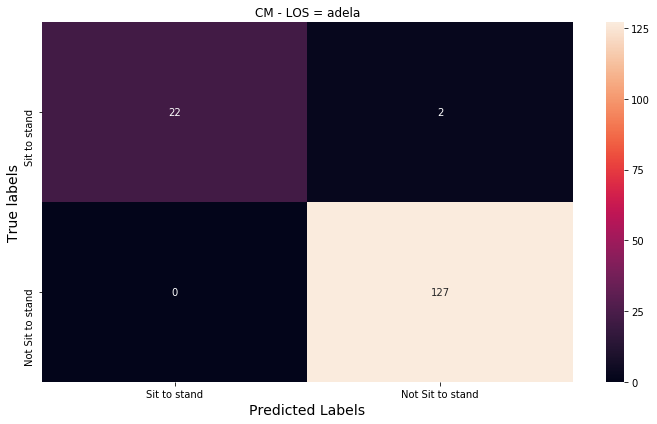

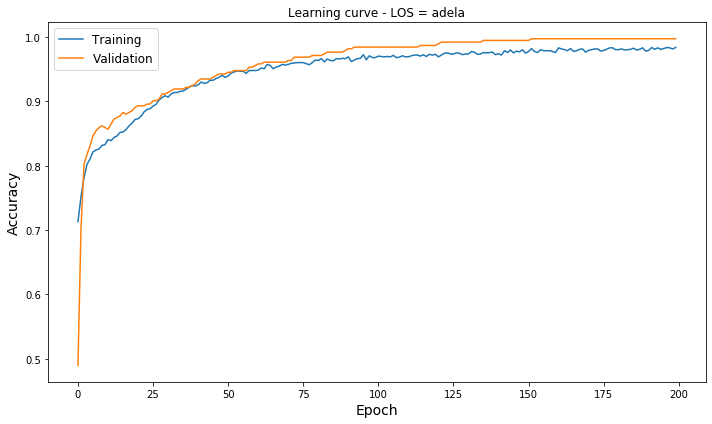

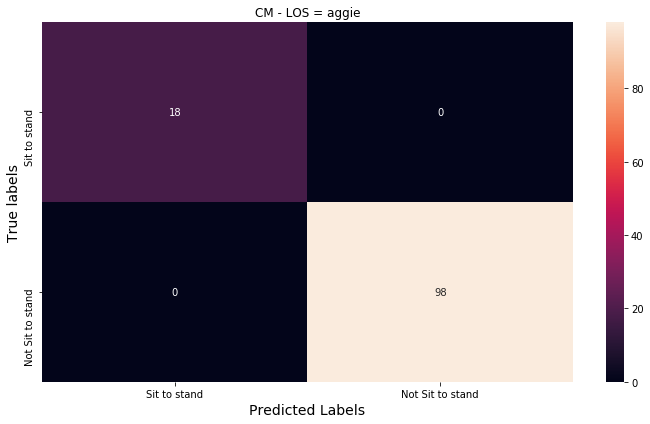

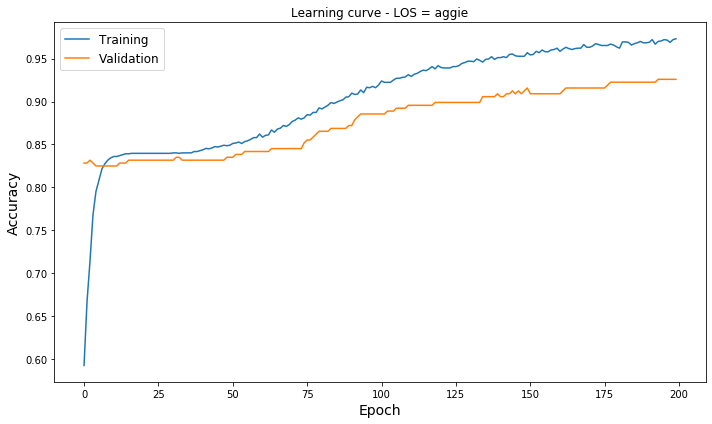

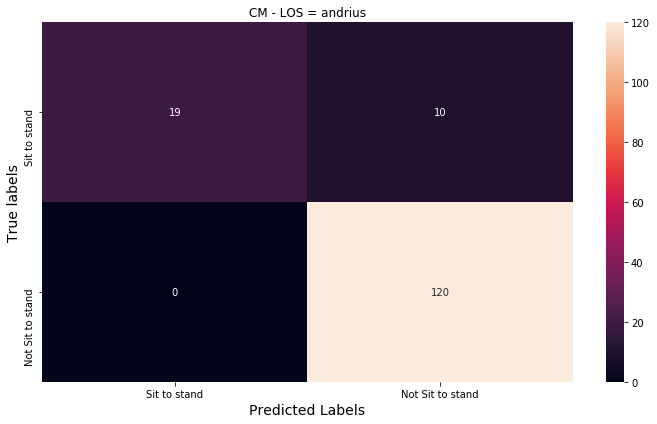

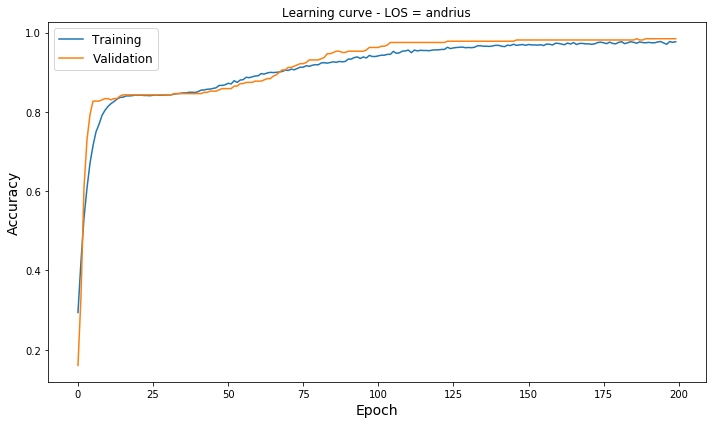

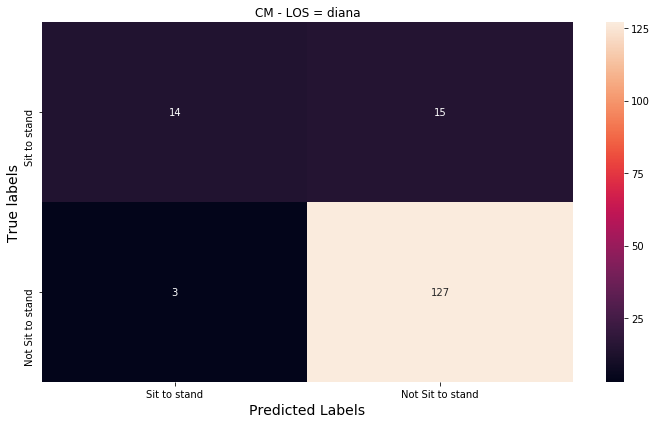

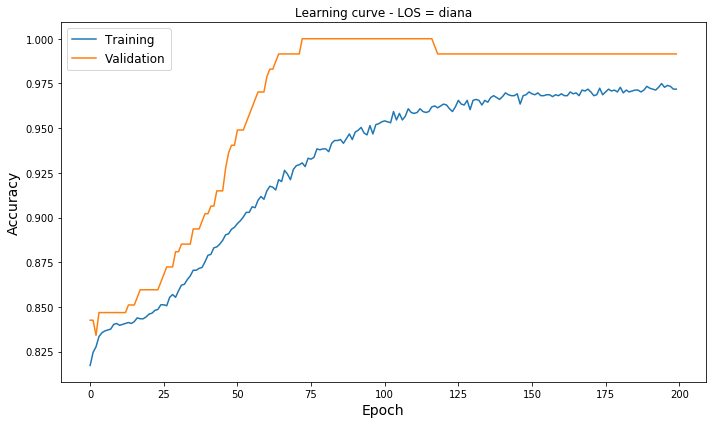

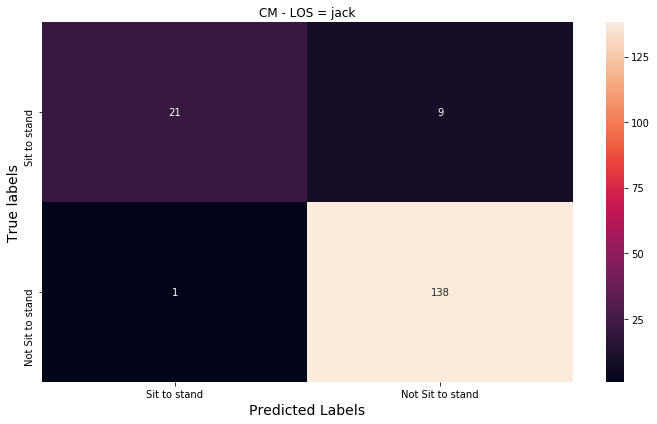

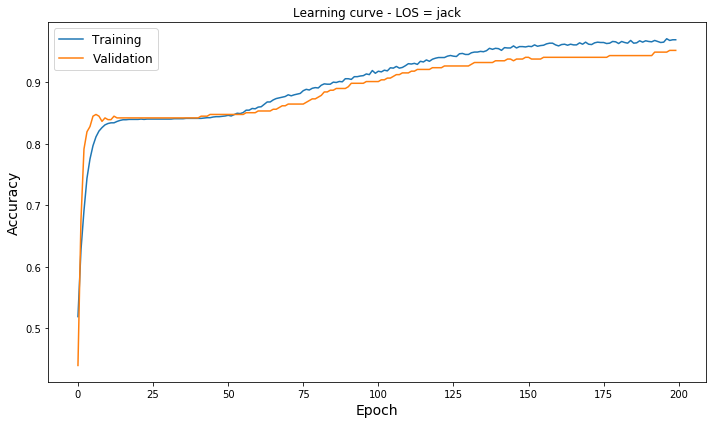

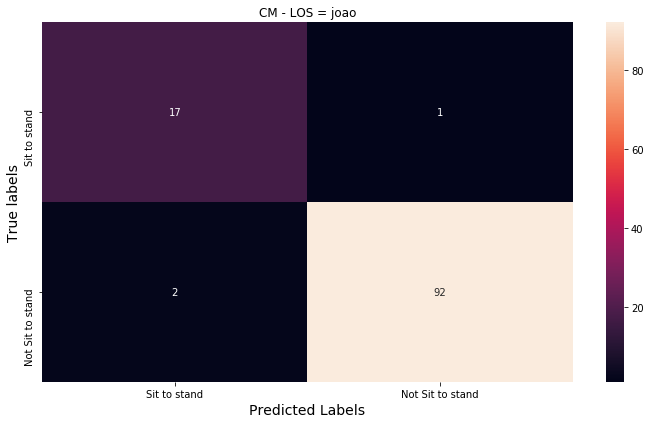

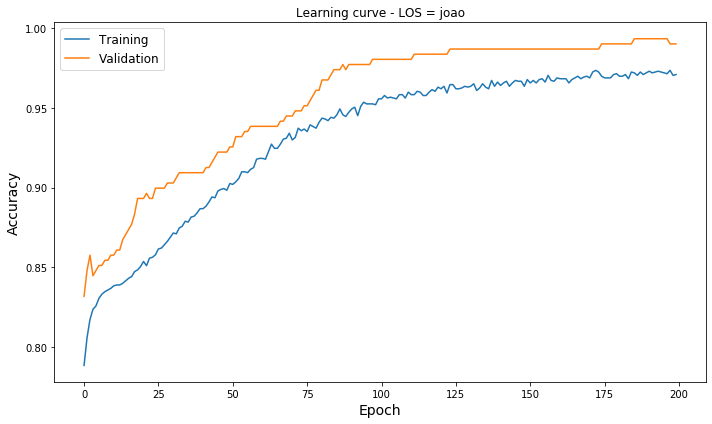

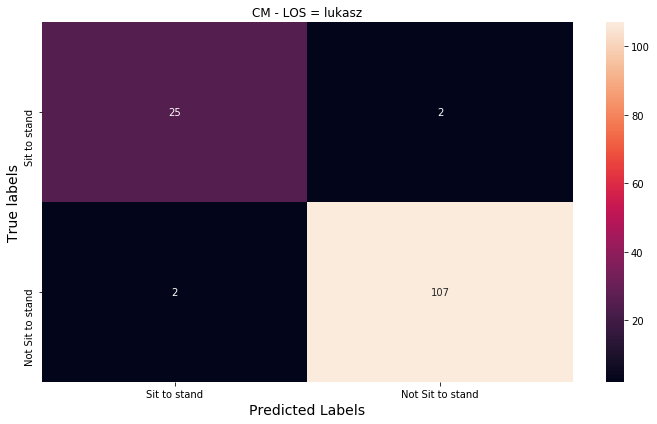

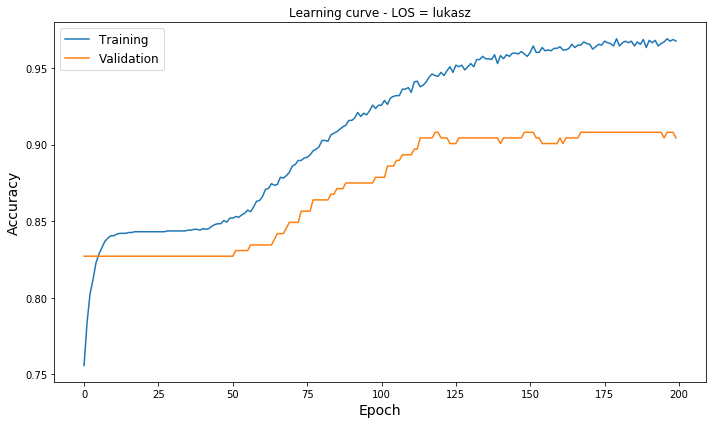

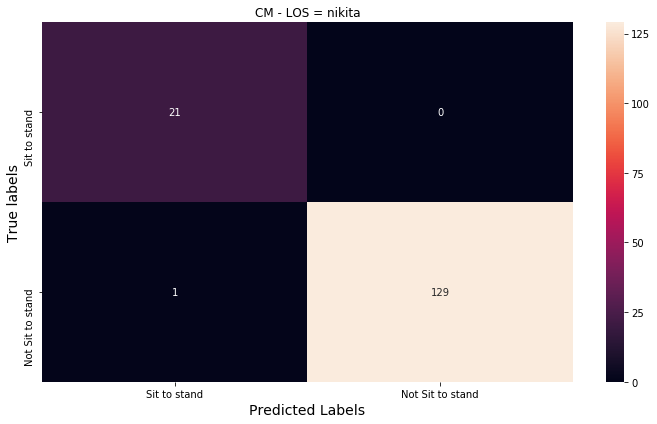

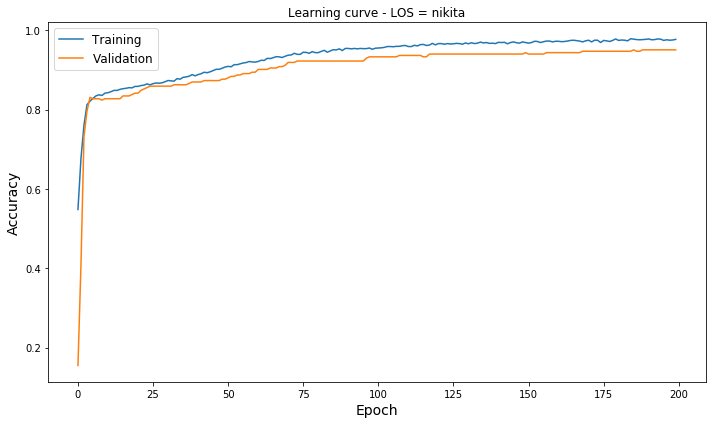

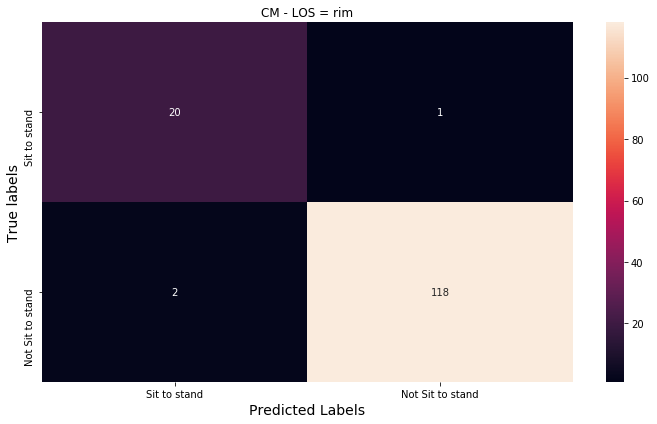

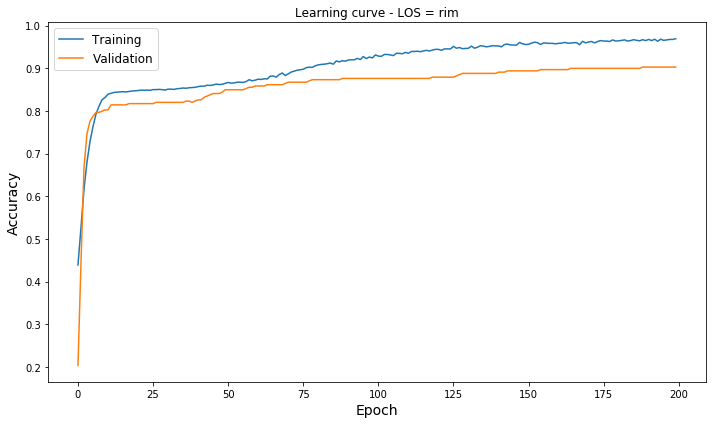

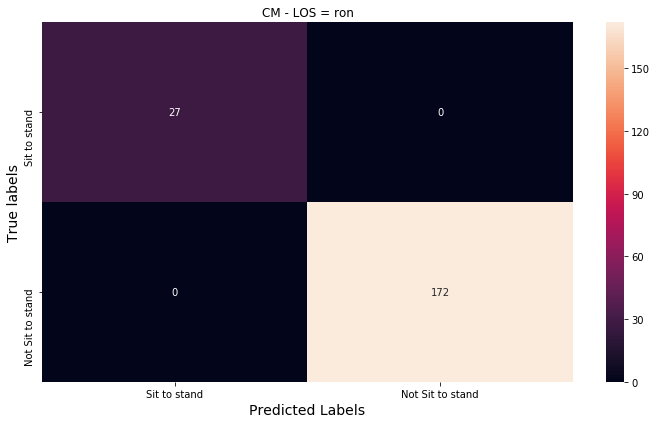

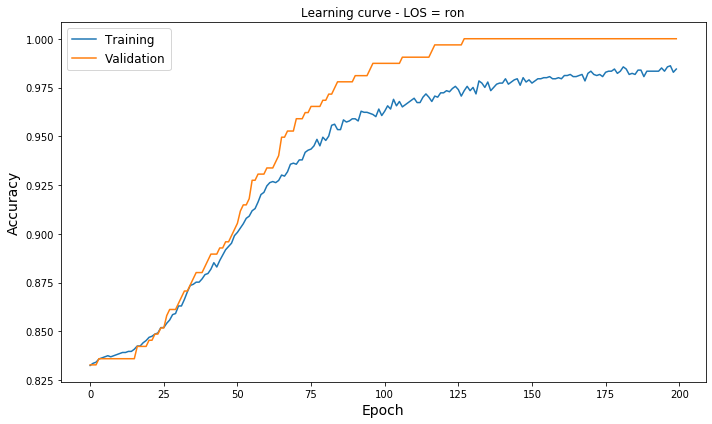

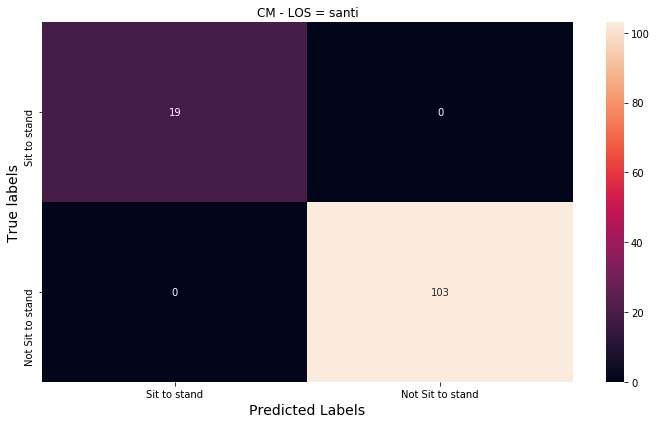

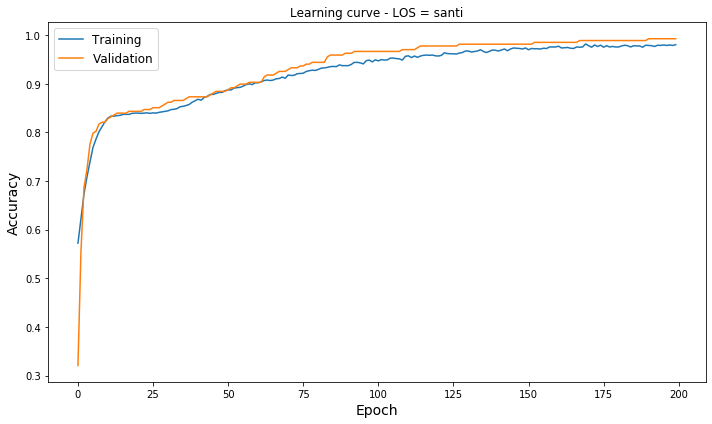

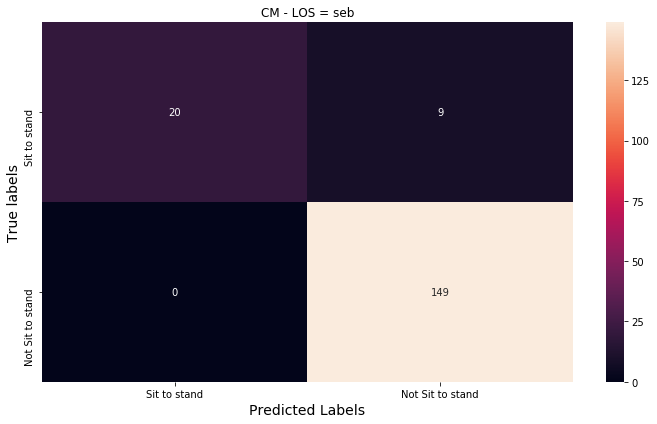

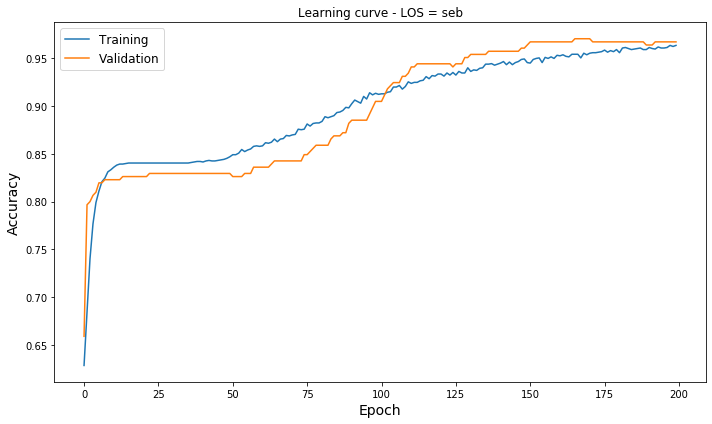

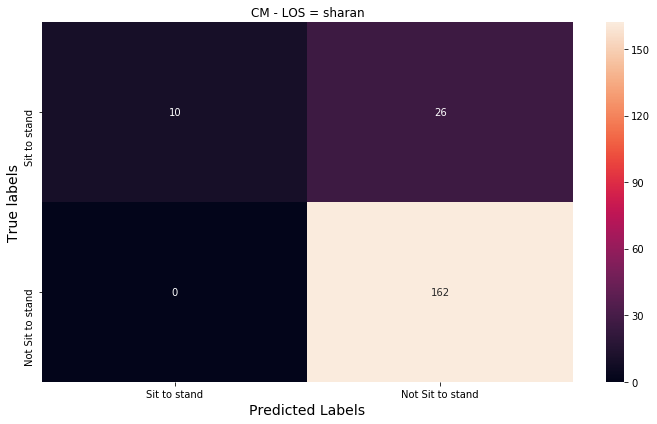

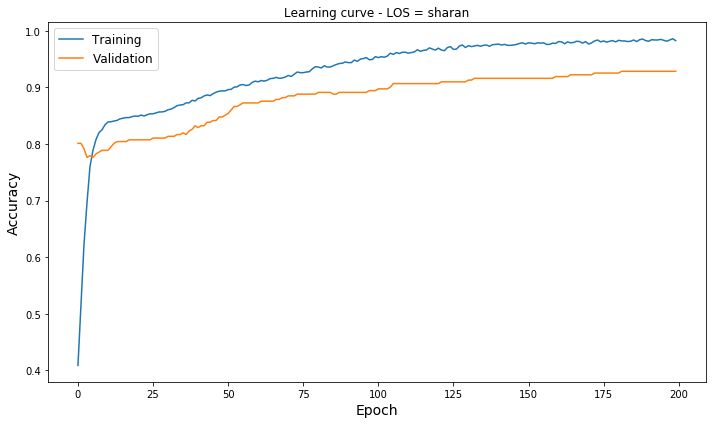

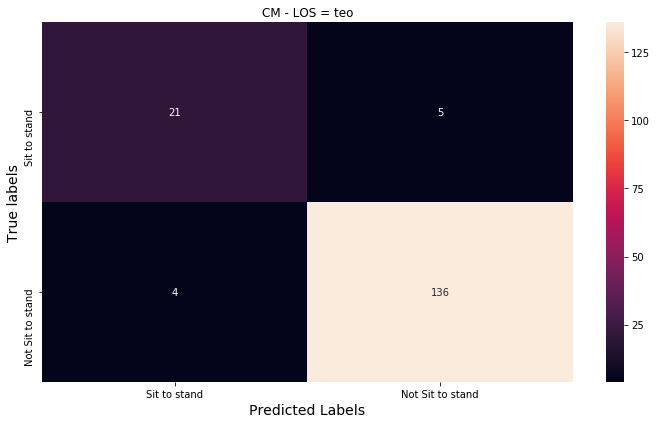

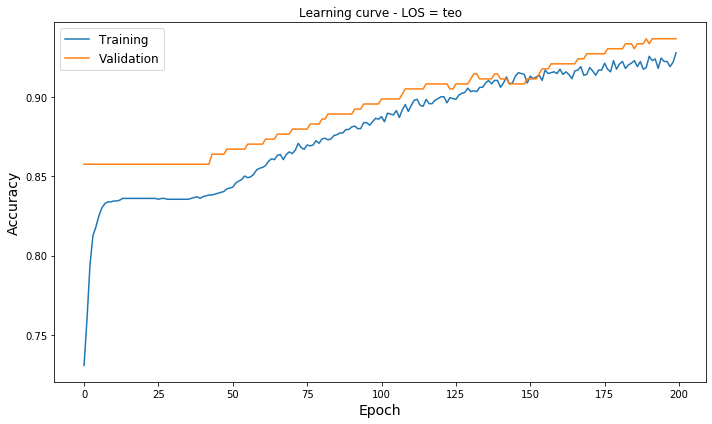

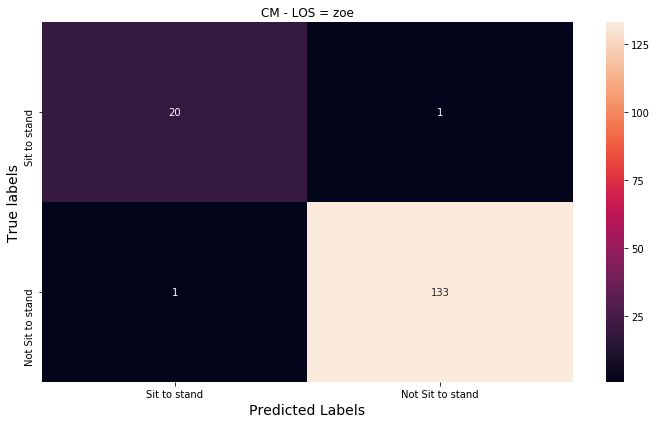

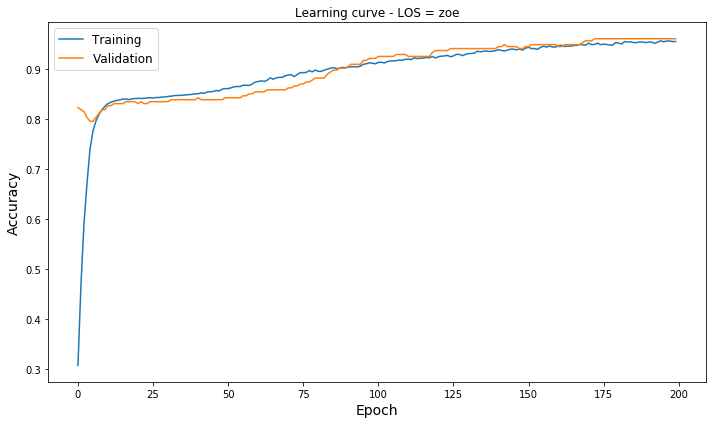

In [44]:
for i in range(len(subjects)):
    
#     early stopping for testing
#     if i > 1:
#         break
    
    # generate training, validation and test subjects
    
    left_out_subject = subjects[i]
    print("Left out subject = {}".format(subjects[i]))
    
    rng = generate_range(i, n_subjects)
    
    train_subjects = set()
    while(len(train_subjects) < n_train_subjects):
        choice = random.choice(rng)
        train_subjects.add(choice)
    
    # for validation, take the remaining ones
    valid_subjects = [subjects[j] for j in (set(rng) - train_subjects)]
    
    train_subjects = [subjects[j] for j in train_subjects]
    
    print("Test subjects = {}".format(train_subjects))
    print("Validation subjects = {}".format(valid_subjects))
    
    train_valid_subjects = train_subjects + valid_subjects
    
    # split the data
    mask_subj = (data['subject'] == train_valid_subjects[0])
    for tvs in train_valid_subjects:
        mask_subj = mask_subj | (data['subject'] == tvs)
        
    data_train = data[mask_subj]
    data_train.reset_index(drop=True, inplace=True)
    
    data_test = data[data['subject'] == left_out_subject]
    data_test.reset_index(drop=True, inplace=True)
    
    print("-" * 80)
    print("Removing outliers")
    print("-" * 80)
    
    # remove outliers for training
    data_train, _, _ = remove_outliers(data_train, activities=activities, subjects=train_valid_subjects, correctness=correctness)
    
    # remove outliers for test
    data_test, _, _ = remove_outliers(data_test, activities=activities, subjects=[left_out_subject], correctness=correctness)
    
    print("-" * 80)
    print("Standardising")
    print("-" * 80)
    
    # standardise for training
    data_train = standardise_data(data_train, activities=activities, subjects=train_valid_subjects, correctness=correctness)
    
    # standardise for test
    data_test = standardise_data(data_test, activities=activities, subjects=[left_out_subject], correctness=correctness)
    
    print("-" * 80)
    print("Normalising")
    print("-" * 80)
    
    # normalise for training
    data_train, scaler_fit = normalise_data(data_train, activities=activities, subjects=train_valid_subjects, correctness=correctness)
    
    # normalise for test
    data_test, _ = normalise_data(data_test, activities=activities, subjects=[left_out_subject], 
                                  correctness=correctness, scaler_fit=scaler_fit)
    
    print("-" * 80)
    print("Generating datasets")
    print("-" * 80)
    
    # Generate datasets
    X_train, y_train = generate_dataset(df=data_train, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=features,
                                   one_vs_all_activity=one_vs_all_activity, subjects=train_subjects, 
                                        correctness=correctness, downsample_rate=4)
    
    print("Training set shapes: X_train = {}, y_train = {}".format(X_train.shape, y_train.shape))
    
    X_valid, y_valid = generate_dataset(df=data_train, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=features,
                                   one_vs_all_activity=one_vs_all_activity, subjects=valid_subjects, 
                                        correctness=correctness, downsample_rate=4)
    
    print("Valid set shapes: X_valid = {}, y_valid = {}".format(X_valid.shape, y_valid.shape))
    
    X_test, y_test = generate_dataset(df=data_test, n_time_steps=n_time_steps, n_features=n_features,
                                   step=step, features=features,
                                   one_vs_all_activity=one_vs_all_activity, subjects=[left_out_subject], 
                                      correctness=correctness, downsample_rate=4)
    
    print("Test set shapes: X_test = {}, y_test = {}".format(X_test.shape, y_test.shape))
    
    # create new model
    model = initialise_model()

    # compile model
    model.compile(optimizer=sgd,
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'mse'])

    history = model.fit(X_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       validation_data=(X_valid, y_valid))
    
    # stats
    y_pred_ohe = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_ohe, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    activity_labels = get_activity_label_dict()
    cm_labels = [activity_labels[one_vs_all_activity], "Not {}".format(activity_labels[one_vs_all_activity])]

    confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
    fig = plt.figure(figsize=(10, 6))
    ax = sns.heatmap(confusion_matrix, xticklabels=cm_labels, yticklabels=cm_labels, annot=True, fmt='d')
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True labels", fontsize=14)
    plt.title("CM - LOS = {}".format(left_out_subject))
    fig.tight_layout()
    plt.savefig(save_path + "{}_CM_LOS.pdf".format(left_out_subject))
    
    fig = plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.title("Learning curve - LOS = {}".format(left_out_subject))
    plt.legend(fontsize=12)
    fig.tight_layout()
    plt.savefig(save_path + "{}_LC_LOS.pdf".format(left_out_subject))
    
    # record stats
    losoxv_stats.loc[left_out_subject, 'train_acc'] = history.history['accuracy'][-1]
    losoxv_stats.loc[left_out_subject, 'train_loss'] = history.history['loss'][-1]
    losoxv_stats.loc[left_out_subject, 'valid_acc'] = history.history['val_accuracy'][-1]
    losoxv_stats.loc[left_out_subject, 'valid_loss'] = history.history['val_loss'][-1]
    
    final_loss, final_acc, final_mse = model.evaluate(X_test, y_test, batch_size)
    print("Final loss = {}".format(final_loss))
    print("Final accuracy = {}".format(final_acc))
    
    losoxv_stats.loc[left_out_subject, 'test_acc'] = final_acc
    losoxv_stats.loc[left_out_subject, 'test_loss'] = final_loss
    
    # update cm and history
    cm[left_out_subject] = confusion_matrix
    histories[left_out_subject] = history

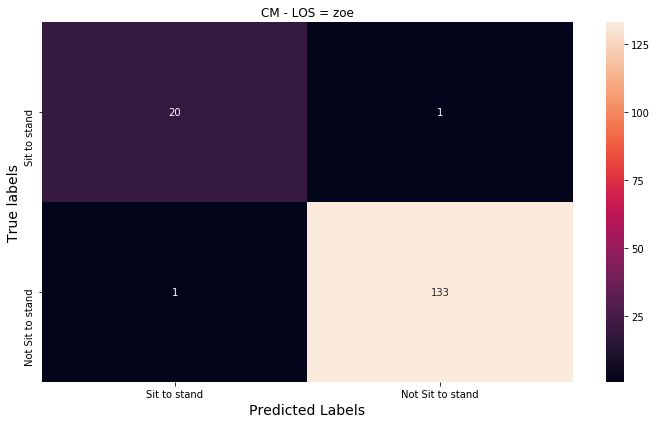

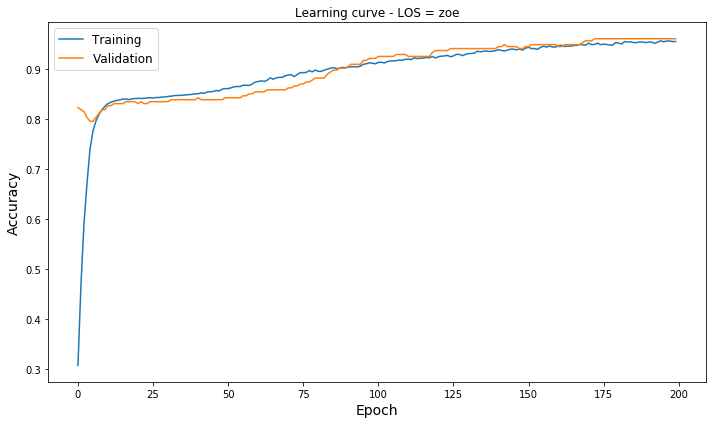

In [45]:
# stats
y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

activity_labels = get_activity_label_dict()
cm_labels = [activity_labels[one_vs_all_activity], "Not {}".format(activity_labels[one_vs_all_activity])]

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(confusion_matrix, xticklabels=cm_labels, yticklabels=cm_labels, annot=True, fmt='d')
plt.xlabel("Predicted Labels", fontsize=14)
# plt.setp(ax.get_xticklabels(), ha="right", rotation=0)
plt.ylabel("True labels", fontsize=14)
plt.title("CM - LOS = {}".format(left_out_subject))
fig.tight_layout()
plt.savefig(save_path + "{}_CM_LOS.pdf".format(left_out_subject))

fig = plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Learning curve - LOS = {}".format(left_out_subject))
plt.legend(fontsize=12)
fig.tight_layout()
plt.savefig(save_path + "{}_LC_LOS.pdf".format(left_out_subject))

In [46]:
losoxv_stats.to_csv("../Plots/07_Sit_to_stand/baseline_stats_losoxv.csv")

In [47]:
import pickle
pickle.dump(cm, open("../Plots/07_Sit_to_stand/cms.p", 'wb'))
pickle.dump(histories, open("../Plots/07_Sit_to_stand/histories.p", 'wb'))

In [48]:
mean_cm = np.zeros(cm['adela'].shape)
for subj in subjects:
    mean_cm += cm[subj]

mean_cm /= len(subjects)

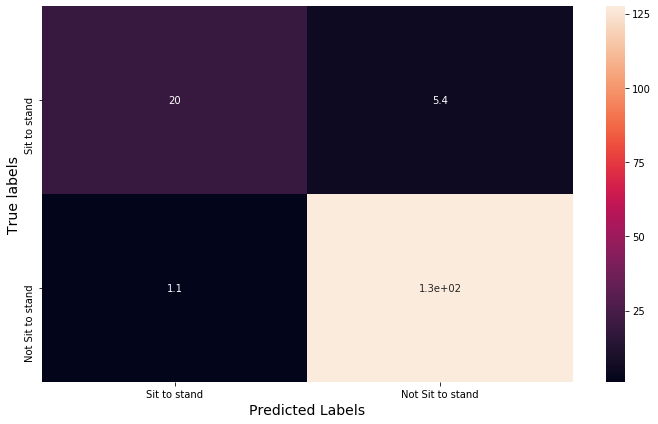

In [50]:
fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(mean_cm, xticklabels=cm_labels, yticklabels=cm_labels, annot=True)
plt.xlabel("Predicted Labels", fontsize=14)
# plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.ylabel("True labels", fontsize=14)
fig.tight_layout()
plt.savefig("../Plots/07_Sit_to_stand/mean_cm_losoxv.pdf")

In [51]:
training_lines = []
validation_lines = []

for subj in subjects:
    training_lines.append(histories[subj].history['accuracy'])
    validation_lines.append(histories[subj].history['val_accuracy'])

training_lines = np.asarray(training_lines)
validation_lines = np.asarray(validation_lines)

In [52]:
# mean and std of the learning curves
training_mean = np.mean(training_lines, axis=0)
validation_mean = np.mean(validation_lines, axis=0)

training_std = np.std(training_lines, axis=0)
validation_std = np.std(validation_lines, axis=0)

print(training_mean.shape)

(200,)


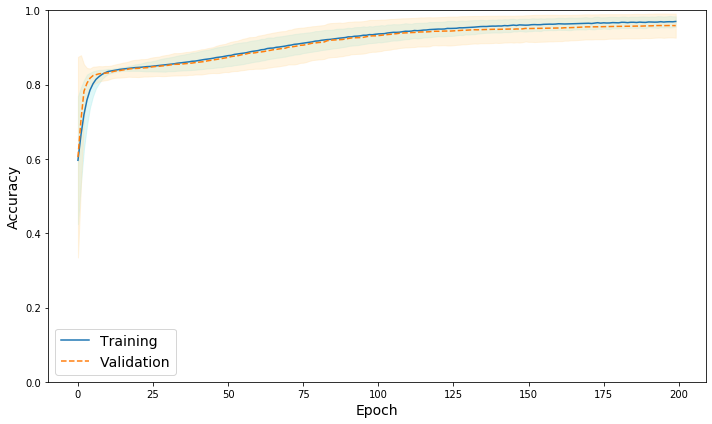

In [54]:
fig = plt.figure(figsize=(10,6))
plt.plot(training_mean, label='Training')
plt.plot(validation_mean, '--', label='Validation')

# Draw bands
plt.fill_between(range(epochs), training_mean - training_std, training_mean + training_std, color="paleturquoise", alpha=0.4)
plt.fill_between(range(epochs), validation_mean - validation_std, validation_mean + validation_std, color="moccasin", alpha=0.4)

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim((0, 1))
plt.legend(fontsize=14)

fig.tight_layout()
plt.savefig("../Plots/07_Sit_to_stand/mean_LC_losoxv.pdf")